# Reinsurance Retention Optimization
# MTPL ELC & MOD CAT ELC
## Renewal 2023

#### Import Library

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import scipy as sp
from scipy import interpolate
import matplotlib.pyplot as plt
from itertools import chain
from scipy.optimize import minimize_scalar
import time
import seaborn as sns

%matplotlib notebook

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
import time
start_time = time.time()

from scipy.stats import norm
from numpy.random import lognormal
from numpy.random import seed

#### Current Retention

In [2]:
'''
Get RI retention from Treaty
'''
MTL_CUR_RET = 400*10**6 #MTPL ELC 400mJPY
MOD_CUR_RET = 400*10**6 #MOD CAT ELC 400mJPY

#### Additional Retentions for Stats

In [3]:
'''
Use these info for summary stats and risk appetite
'''
MTL_ADD_RET = [300000000, 500000000, 600000000, 999999999, 200000000]
MOD_ADD_RET = [300000000, 500000000, 600000000, 999999999, 200000000]

#### Reinsurance Ceded Premium and GNPI for Current Treaty Year per Treaty

In [4]:
#Refert to treaty, update done 202211
MTL_RIP = [7165867, 4086549, 1651131, 2146470] 
MTL_GNPI = 41421194462
# MOD not updated for Ren2021 as it is 3yr contract
MOD_RIP = [39383298, 21332619, 3749821 + 9162369, 1219995]#by layer #4 layers in Ren2019 addendum in 3rd layer
MOD_GNPI = 16409707294

#### Rate on Premium for 2nd, 3rd and 4th UL XoL layers (no 1st layer)

In [5]:
#Ren2021 update done for MTL
#In percent i.e. 0.0144 = 0.0144%
MTL_RoP2 = 0.0191 #add RI rates for 2nd layer and above
MOD_RoP2 = (0.13 + ((3749821 + 9162369 + 1219995) / MOD_GNPI) * 100) * 1.1 #2nd layer and 3rd and 4th for multiyear

#### QS Cession Rate

In [6]:
QS_RATE = 0.03 #Used for net calculation

#### Scaling Factor for Strips (when figures for next year is not available at the execution.)

In [7]:
# Scaling Factor = Current Year / Previous Year
def scale_factor(flag, current_pml, previous_pml):
    """
    This function calculates scaling factor.
    When next year information is not available, scaling factor is required.
    """
    if flag:
        mtl_scale = current_pml / previous_pml
        return mtl_scale
    else:
        return 1.0

#### Scaling Factor

In [8]:
#Input for scaling facor calculation
#update done 20190930
'''
required when ATY and/or CAT Strip for current year are not available.
'''
MTL_USE_SCALING_FACTOR = False #True for using scaling factor, False for not using
MOD_USE_SCALING_FACTOR = False #True for using scaling factor, False for not using

#Use PML @200yr in millions JPY
#MTL Previous Year
MTL_PML_PREVIOUS_YEAR = 2878.0
#MTL Current Year
MTL_PML_CURRENT_YEAR = 2953.0
#MTL Scaling Factor
MTL_SCALING_FACTOR = scale_factor(MTL_USE_SCALING_FACTOR, MTL_PML_CURRENT_YEAR, MTL_PML_PREVIOUS_YEAR)
    
#MOD CAT Previous Year
EW_PML_PREVIOUS_YEAR = 2363.0
EQ_PML_PREVIOUS_YEAR = 2275.0 
EF_PML_PREVIOUS_YEAR = 1781.0 
TH_PML_PREVIOUS_YEAR = 187.0 
OT_PML_PREVIOUS_YEAR = 746.0 
#MOD CAT Current Year
EW_PML_CURRENT_YEAR = 2574.0
EQ_PML_CURRENT_YEAR = 2983.0
EF_PML_CURRENT_YEAR = 2007.0
TH_PML_CURRENT_YEAR = 597.0
OT_PML_CURRENT_YEAR = 842.0
#MOD CAT Scaling Factor 
EW_SCALING_FACTOR = scale_factor(MOD_USE_SCALING_FACTOR, EW_PML_CURRENT_YEAR, EW_PML_PREVIOUS_YEAR)
EQ_SCALING_FACTOR = scale_factor(MOD_USE_SCALING_FACTOR, EQ_PML_CURRENT_YEAR, EQ_PML_PREVIOUS_YEAR)
EF_SCALING_FACTOR = scale_factor(MOD_USE_SCALING_FACTOR, EF_PML_CURRENT_YEAR, EF_PML_PREVIOUS_YEAR)
TH_SCALING_FACTOR = scale_factor(MOD_USE_SCALING_FACTOR, TH_PML_CURRENT_YEAR, TH_PML_PREVIOUS_YEAR)
OT_SCALING_FACTOR = scale_factor(MOD_USE_SCALING_FACTOR, OT_PML_CURRENT_YEAR, OT_PML_PREVIOUS_YEAR)

#### Optimization Boundary

In [9]:
BOUND = (200000000, 999999999) #optimized retention is searched within this boundary.

#### Input for Risk Appetite

In [10]:
#update done 202211
UE = 4356644125  #SP2022 per Strategic Plan
UE_50PCT = UE * 0.5
PC_UE = 3810296382  #PC UE post tax
'''
SP2021
PC Technical Result: 4827941095
Investment Return: 403862741
Tax: -1463858714
PC Technical Result post Tax: 3477083177 = (4827941095 /(4827941095 + 403862741)) * -1463858714 + 4827941095
PC UE post tax = (PC Technical Result / (PC Technical Result + IR)) * Tax + PC Technical Result
UE: 3767945123
'''
AFR = 30961000000  #FY2023per STEC Projection
'''
AFR(EoF) in Euro: 215 mEuro
FX: 124yen
AFR(EoF) in JPY: 26623832824 yen

'''
AFR_30PCT = AFR * 0.3
COMPANY_STEC = 12623292048 #FY2022 per STEC Projection
COVERAGE_RATIO = AFR / COMPANY_STEC

In [11]:
COVERAGE_RATIO

2.452688243468579

#### Read CSV data

In [12]:
#MTPL
"""
************* This cell, Update done on 2019/9/12

For aty_exp, Remetrica workbook is required to extract expense part.

In Remetrica

- For MTL_ATY.csv
1. Use Loss Packager to extract Atypical loss by Per Msg by Trial
2. Go to Remetrica workbook, "Aty" sheet and samplevalues the ATY losses by year
3. Copy&Paste the 2's result in MTL_ATY.csv file and save the file in the same directory as this program is saved.

- For ATY_EXP
4. In Remetrica workbook, Go to "Summary" sheet and samplevalues the Atypical Gross Losses Undiscounted from DiscountCF component
5. Sum the 2's result by year
6. Take the difference btw 4 and 5 as ATY Expense
7. Copy&Paste the 6's result in "ATY_EXP.csv" file and save the file in the same directory as this program is saved.
8. The end of ATY_EXP treatment

"""
mtl_data = pd.read_csv("MTL_ATY.csv")
#mtl_data = mtl_csv.drop(['counts'], axis=1)
data = pd.melt(mtl_data,id_vars=['realization'])
data = data.sort_values(by='realization')
data = data[data['value'] > 0]
rea_mtl = data[['realization','value']] #realization, value = loss amount
rea_mtl['value'] = rea_mtl['value'] * MTL_SCALING_FACTOR # adjusted by scaling factor when necessary
mtpl_df = pd.read_csv("MTPL.csv") # Reinsurance rate on premium
aty_exp = pd.read_csv("ATY_EXP.csv") # ATY expense from Remetrica workbook output
df_prem_rank = pd.read_csv('Conso_HY20_FinalPremiumRank.csv')['AGD_Direct_Japan']#To sort MTL strip for aggregation

In [13]:
mtpl_df

,Ret,RoP
0,300,0.107891
1,400,0.036400
2,500,0.025500
3,600,0.019475
4,1000,0.019100


In [ ]:
#MOD CAT
"""
For CAT strips
1. CAT strips by perils are delivered by GRM (EQ, EF, OT, TH, EW)
2. save strips with following name convenion, rea_EQ.csv, rea_EF.csv...etc
3. Ready to be used in this program

For CAT_Add
1. Use Loss Packager to extract CAT loss by Per Msg by Trial
2. Go to Remetrica workbook, "CAT" sheet, and samplevalues the CAT losses by year
3. Similar to ATY but no need to copy&paste the 2's result in csv because CAT strips take care of this treatment.
For "CAT_Additional.csv"
    Three columns, "CAT_Exp", "CAT_Net_Prem", "CAT_Net_Exp"
4. In Remetrica workbook, Go to "Summary" sheet and samplevalues the CAT Gross Losses Undiscounted from DiscountCF component
5. Sum the 2's result by year
6. Take the difference btw 4 and 5 as expense
7. Copy&Paste the 6's result in CAT_Addtional.csv file and save the file in the same directory as this program is saved.
8. Samplevalues the CAT Net Premium Discounted from DiscountCF component
9. Samplevalues the CAT Net Expense Discounted from DiscountCF component
10. Copy&Paste the 8's and 9's result in CAT_Addtional.csv file and save the file in the same directory as this program is saved.
11. the end of CAT strips and CAT_Add treatment
"""
#For CAT_ATY.csv
CAT_data = pd.read_csv("CAT_ATY.csv")
data = pd.melt(CAT_data,id_vars=['realization'])
data = data.sort_values(by='realization')
data = data[data['value'] > 0]
#For MOD.csv
MOD_df = pd.read_csv("MOD.csv")
#Using CAT strips directly provided by GRM
#WS
rea_EW = pd.read_csv("f1_PTY_DJP_ASX_ASX_WS_01_003000_JPY.CSV").drop(['EventID', 'SD'],axis=1)
rea_EW.columns = ['realization','value']
rea_EW['value'] = rea_EW['value'] * EW_SCALING_FACTOR # adjusted by scaling factor when necessary
#EQ
rea_EQ = pd.read_csv("f1_PTY_DJP_ASX_ASX_EQ_01_003000_JPY.CSV").drop(['EventID', 'SD'],axis=1)
rea_EQ.columns = ['realization','value']
rea_EQ['value'] = rea_EQ['value'] * EQ_SCALING_FACTOR # adjusted by scaling factor when necessary
#Flood
rea_EF = pd.read_csv("f1_PTY_DJP_JPN_JPN_FL_01_003000_JPY.CSV").drop(['EventID', 'SD'],axis=1)
rea_EF.columns = ['realization','value']
rea_EF['value'] = rea_EF['value'] * EF_SCALING_FACTOR # adjusted by scaling factor when necessary
#Hail
rea_TH = pd.read_csv("f1_PTY_DJP_JPN_JPN_TH_01_003000_JPY.CSV").drop(['EventID', 'SD'],axis=1)
rea_TH.columns = ['realization','value']
rea_TH['value'] = rea_TH['value'] * TH_SCALING_FACTOR # adjusted by scaling factor when necessary
#Snow as other
rea_OT = pd.read_csv("f1_PTY_DJP_JPN_JPN_SN_01_003000_JPY.CSV").drop(['EventID', 'SD'],axis=1)
rea_OT.columns = ['realization','value']
rea_OT['value'] = rea_OT['value'] * OT_SCALING_FACTOR # adjusted by scaling factor when necessary
#Append CAT strips
rea_CAT = rea_EF.append(rea_OT).append(rea_TH).append(rea_EW).append(rea_EQ)
rea_CAT = rea_CAT.sort_values(by='realization')
#For CAT_Addtional.csv
CAT_Add = pd.read_csv('CAT_Additional.csv') # CAT addtional info like expense from Remetrica workbook output

In [ ]:
rea_CAT[rea_CAT['value'] > 400000000].count()

In [ ]:
rea_CAT.to_csv("cat_strips_for_op.csv")

In [ ]:
rea_CAT[rea_CAT['value'] > 400000000].count() / rea_CAT.count()

In [ ]:
rea_CAT[rea_CAT['value'] > 400000000].to_csv("cat_4m.csv")

#### Input for PCMR (used for P&C STEC calculation)

In [16]:
df_trial = pd.read_csv('05 HY2022 Full calculation_Final_2022_09_06_Trial.csv')
df_stats = pd.read_csv('05 HY2022 Full calculation_Final_2022_09_06_Stat.csv')
df_corr = pd.read_csv('Correlation_Matrix.csv')
df_res_rank = pd.read_csv('Conso_HY20_FinalReserveRank.csv')['AGD_Direct_Japan'] #rank matrixは過去のものを使う
df_prem_rank = pd.read_csv('Conso_HY20_FinalPremiumRank.csv')['AGD_Direct_Japan']
norm_var995 = norm.ppf(0.995)

#### Strips for PCMR

In [33]:
#Reserve Strips
init_res = df_stats[df_stats['Property']=='Initial Reserves Discounted']
covnm = []
num = 0
while num < init_res.shape[0]:
    cn = str(init_res.iloc[num,0]).split('/')[2]
    covnm.append(cn)
    num += 1 
ir = pd.DataFrame(init_res['Mean'])
ir['Cov_Name'] = covnm
#MOH
MOH_str1 = df_trial['/Motor/MOH/Discounted Reporting/DiscountCF>Runoff Result Discounted_Item 1']
MOH_Res_Str = np.array(ir[ir['Cov_Name']=='MOH']['Mean'])-MOH_str1
#MTL
MTL_str1 = df_trial['/Motor/MTL/Discounted Reporting/DiscountCF>Runoff Result Discounted_Item 1']
MTL_Res_Str = np.array(ir[ir['Cov_Name']=='MTL']['Mean'])-MTL_str1
#PAC
PAC_str1 = df_trial['/Other/PAC/Discounted Reporting/DiscountCF>Runoff Result Discounted_Item 1']
PAC_Res_Str = np.array(ir[ir['Cov_Name']=='PAC']['Mean'])-PAC_str1

#Premium Strips
MOH_Prem_Str = df_trial['/Motor/MOH/Discounted Reporting/DiscountCF>ATT & ATY Net Result Discounted_Item 1']
MTL_Prem_Str = df_trial['/Motor/MTL/Discounted Reporting/DiscountCF>ATT & ATY Net Result Discounted_Item 1']
PAC_Prem_Str = df_trial['/Other/PAC/Discounted Reporting/DiscountCF>ATT & ATY Net Result Discounted_Item 1']

#Portfolio Strips
MOH_Port_Str = (df_trial['/Motor/MOH/Discounted Reporting/DiscountCF>Net Premium Discounted'] - 
                df_trial['/Motor/MOH/Discounted Reporting/DiscountCF>Net Expense Discounted'])
MTL_Port_Str = (df_trial['/Motor/MTL/Discounted Reporting/DiscountCF>Net Premium Discounted'] - 
                df_trial['/Motor/MTL/Discounted Reporting/DiscountCF>Net Expense Discounted'])
PAC_Port_Str = (df_trial['/Other/PAC/Discounted Reporting/DiscountCF>Net Premium Discounted'] -
                df_trial['/Other/PAC/Discounted Reporting/DiscountCF>Net Expense Discounted'])

#Attritional Strips
MOH_ATT_Str = df_trial['/Motor/MOH/Discounted Reporting/DiscountCF>Attritional Net Losses Discounted']
MTL_ATT_Str = df_trial['/Motor/MTL/Discounted Reporting/DiscountCF>Attritional Net Losses Discounted']
PAC_ATT_Str = df_trial['/Other/PAC/Discounted Reporting/DiscountCF>Attritional Net Losses Discounted']

#Atypical Strips
MOH_ATY_Str = df_trial['/Motor/MOH/Discounted Reporting/DiscountCF>Atypical Net Losses Discounted']
MTL_ATY_Str = df_trial['/Motor/MTL/Discounted Reporting/DiscountCF>Atypical Net Losses Discounted']
PAC_ATY_Str = df_trial['/Other/PAC/Discounted Reporting/DiscountCF>Atypical Net Losses Discounted']

#CAT Strips
MOH_CAT_Str = -df_trial['/Motor/MOH/Discounted Reporting/DiscountCF>CAT Net Result Discounted_Item 1']
MTL_CAT_Str = -df_trial['/Motor/MTL/Discounted Reporting/DiscountCF>CAT Net Result Discounted_Item 1']
PAC_CAT_Str = -df_trial['/Other/PAC/Discounted Reporting/DiscountCF>CAT Net Result Discounted_Item 1']
MOH_EW_Str = df_trial['/Motor/MOH/Discounted Reporting/DiscountCF>Windstorm Net Losses Discounted'] #EurowindからWindstormに変更
MOH_EQ_Str = df_trial['/Motor/MOH/Discounted Reporting/DiscountCF>Earthquake Net Losses Discounted']
MOH_FL_Str = df_trial['/Motor/MOH/Discounted Reporting/DiscountCF>Flood Net Losses Discounted']
MOH_OT_Str = df_trial['/Motor/MOH/Discounted Reporting/DiscountCF>Snow Net Losses Discounted'] #Other CAT to Snow
MOH_OT_Str = df_trial['/Motor/MOH/Discounted Reporting/DiscountCF>Hail Net Losses Discounted'] #Hail added

#UPR Strips
MOH_UPR_Str = df_trial['/Motor/MOH/Premiums/Portfolio>Current Year UPR']
MTL_UPR_Str = df_trial['/Motor/MTL/Premiums/Portfolio>Current Year UPR']
PAC_UPR_Str = df_trial['/Other/PAC/Premiums/Portfolio>Current Year UPR']

#Net Loss Discounted
MOH_NLD_Str = df_trial['/Motor/MOH/Discounted Reporting/DiscountCF>Attritional Net Losses Discounted']
MTL_NLD_Str = df_trial['/Motor/MTL/Discounted Reporting/DiscountCF>Attritional Net Losses Discounted']
PAC_NLD_Str = df_trial['/Other/PAC/Discounted Reporting/DiscountCF>Attritional Net Losses Discounted']

#Net Expense Discounted
MOH_NED_Str = df_trial['/Motor/MOH/Discounted Reporting/DiscountCF>Net Expense Discounted']
MTL_NED_Str = df_trial['/Motor/MTL/Discounted Reporting/DiscountCF>Net Expense Discounted']
PAC_NED_Str = df_trial['/Other/PAC/Discounted Reporting/DiscountCF>Net Expense Discounted']

#Net Premium Discounted
MOH_NPD_Str = df_trial['/Motor/MOH/Discounted Reporting/DiscountCF>Net Premium Discounted']
MTL_NPD_Str = df_trial['/Motor/MTL/Discounted Reporting/DiscountCF>Net Premium Discounted']
PAC_NPD_Str = df_trial['/Other/PAC/Discounted Reporting/DiscountCF>Net Premium Discounted']

# Attritional Gross Loss Discounted for MTL
MTL_ATT_GL_Str = df_trial['/Motor/MTL/Discounted Reporting/DiscountCF>Attritional Gross Losses Discounted']
MTL_ATT_ATY_GL_Str = df_trial['/Motor/MTL/Discounted Reporting/DiscountCF>ATT & ATY Gross Losses Discounted']

In [34]:
def STEC_Simulation(corr=None, STEC_Type=None, mean=None, Port_Mean=0):
    '''
    関数の目的：Coverage別SETCからSTEC総額（会社計）を計算
    分散効果を加味してCoverage別STECを合算、対数正規分布のパラメータを推計、対数正規分布のシミュレーションからMeanとValue at Riskを推計し、
    STECを計算（VaR－Mean）
    STEC_Type: Coverage別STEC（Var - Mean)
    corr: Coverage別相関行列
    '''
    mat_STEC = np.array(STEC_Type)
    STEC_wht = np.dot(corr, mat_STEC)
    Total_STEC = np.sqrt(np.sum(mat_STEC * STEC_wht))
    Total_VaR = mean + Total_STEC
    LN_var = norm_var995 - np.sqrt(norm_var995 * norm_var995 + 2 * np.log(mean / Total_VaR))
    LN_u = np.log(Total_VaR) - norm_var995 * LN_var
    seed(1) #set seed
    Total_Strip = -np.sort(-lognormal(mean = LN_u, sigma = LN_var, size = 50000))-Port_Mean #size changed to 50k from 10k
    Total_Strip_Mean = Total_Strip.mean()
    Total_Strip_VaR = Total_Strip[249] #VaR99.5 for 50k simulations
    Total_STEC_Fin = Total_Strip_VaR - Total_Strip_Mean
    
    return (Total_STEC_Fin, Total_Strip)

In [35]:
def STEC_Ranking(rank_matrix, strip, sort_flg):
    '''
    関数の目的：Premium STECとReserve STECをランクマトリックスを使って並び替える。
    '''
    if sort_flg == 'ascending':
        strip = np.sort(strip)
        Total_STEC_Rank = [strip[i-1] for i in rank_matrix]
    else:
        strip = np.sort(strip)[::-1]
        Total_STEC_Rank = [strip[i-1] for i in rank_matrix]
    
    return Total_STEC_Rank

In [36]:
def sort_func(strip, sort_flg):
    '''
    関数の目的：Coverage別Stripをソートし、Mean, VaR, STECを計算する。
    結果は、STEC_Simulation関数で使われる。
    '''
    mean = np.mean(strip)
    if sort_flg == 'ascending':
        VaR = np.sort(strip)[249] #VaR99.5 for 50k simulations
    else:
        VaR = np.sort(strip)[::-1][249] #VaR99.5 for 50k simulations
        
    return (mean, VaR - mean)

#### Reserve STEC

In [37]:
MOH_Res_Mean, MOH_Res_STEC = sort_func(MOH_Res_Str, 'descending')
MTL_Res_Mean, MTL_Res_STEC = sort_func(MTL_Res_Str, 'descending')
PAC_Res_Mean, PAC_Res_STEC = sort_func(PAC_Res_Str, 'descending')
#Total
Total_Res_Mean =  MOH_Res_Mean + MTL_Res_Mean + PAC_Res_Mean

STEC_list = [MOH_Res_STEC, MTL_Res_STEC, PAC_Res_STEC]
STEC_Res = pd.DataFrame(STEC_list, columns=['STEC_Reserve'])
#Run Simulation
sim_result = STEC_Simulation(
                            np.array(df_corr.iloc[:,1:]),
                            STEC_Res,
                            Total_Res_Mean,
                            0, #Portfolio Mean, used for only Premium STEC
                        )
Total_Res_STEC_Fin = sim_result[0]
Total_Res_STEC_Rank = STEC_Ranking(df_res_rank, sim_result[1], 'ascending')

#### CAT STEC

In [38]:
Total_CAT_Strip_Mean, Total_CAT_STEC_Fin = sort_func(MOH_CAT_Str, 'descending')
EuroWind_CAT_Strip_Mean, EuroWind_CAT_STEC_Fin = sort_func(MOH_EW_Str, 'descending')
EQ_CAT_Strip_Mean, EQ_CAT_STEC_Fin = sort_func(MOH_EQ_Str, 'descending')
Flood_CAT_Strip_Mean, Flood_CAT_STEC_Fin = sort_func(MOH_FL_Str, 'descending')
Other_CAT_Strip_Mean, Other_CAT_STEC_Fin = sort_func(MOH_OT_Str, 'descending')

#### UPR STEC

In [39]:
#Combined Ratio Strip
MOH_ATT_CR = 1- (MOH_Prem_Str) / MOH_NPD_Str
MTL_ATT_CR = (MTL_NLD_Str / MTL_NPD_Str) * np.mean(MTL_ATT_ATY_GL_Str) / np.mean(MTL_ATT_GL_Str)
PAC_ATT_CR = 1- (PAC_Prem_Str) / PAC_NPD_Str
#UPR Volatility
MOH_UPR_Vola = MOH_UPR_Str * (1-MOH_ATT_CR)
MTL_UPR_Vola = MTL_UPR_Str * (1-MTL_ATT_CR)
PAC_UPR_Vola = PAC_UPR_Str * (1-PAC_ATT_CR)

MOH_UPR_Vola_Mean, MOH_UPR_STEC = sort_func(MOH_UPR_Vola,'ascending')[0], -sort_func(MOH_UPR_Vola,'ascending')[1]
MTL_UPR_Vola_Mean, MTL_UPR_STEC = sort_func(MTL_UPR_Vola,'ascending')[0], -sort_func(MTL_UPR_Vola,'ascending')[1]
PAC_UPR_Vola_Mean, PAC_UPR_STEC = sort_func(PAC_UPR_Vola,'ascending')[0], -sort_func(PAC_UPR_Vola,'ascending')[1]

Total_UPR_Vola_Mean = MOH_UPR_Vola_Mean + MTL_UPR_Vola_Mean + PAC_UPR_Vola_Mean

#Aggregation
STEC_list_UPR = [MOH_UPR_STEC, MTL_UPR_STEC, PAC_UPR_STEC]
STEC_UPR = pd.DataFrame(STEC_list_UPR, columns=['STEC_UPR'])
#Run Simulation
sim_result = STEC_Simulation(
                            np.array(df_corr.iloc[:,1:]),
                            STEC_UPR,
                            Total_UPR_Vola_Mean,
                            0, #Portfolio Mean, used for only Premium STEC
                        )
Total_UPR_Vola_STEC_Fin = sim_result[0]

#### Premium STEC

In [40]:
#Portfolio STEC
MOH_Port_Mean, MOH_Port_STEC = sort_func(MOH_Port_Str,'ascending')[0], -sort_func(MOH_Port_Str,'ascending')[1]
MTL_Port_Mean, MTL_Port_STEC = sort_func(MTL_Port_Str,'ascending')[0], -sort_func(MTL_Port_Str,'ascending')[1]
PAC_Port_Mean, PAC_Port_STEC = sort_func(PAC_Port_Str,'ascending')[0], -sort_func(PAC_Port_Str,'ascending')[1]

Total_Port_Mean = MOH_Port_Mean + MTL_Port_Mean + PAC_Port_Mean

#VaR calibration for Lognormal simulation
STEC_list_Port = [MOH_Port_STEC, MTL_Port_STEC, PAC_Port_STEC]
STEC_Port = pd.DataFrame(STEC_list_Port,columns=['STEC_Portfolio'])
#Run Simulation
sim_result = STEC_Simulation(
                            np.array(df_corr.iloc[:,1:]),
                            STEC_Port,
                            Total_Port_Mean,
                            0, #Portfolio Mean, used for only Premium STEC
                        )
Total_Port_STEC_Fin = sim_result[0]

#Premium STEC
MOH_Prem_UPR_Str = MOH_Prem_Str + MOH_UPR_Vola
MTL_Prem_UPR_Str = MTL_Prem_Str + MTL_UPR_Vola
PAC_Prem_UPR_Str = PAC_Prem_Str + PAC_UPR_Vola

MOH_Prem_Mean, MOH_Prem_STEC = sort_func(MOH_Prem_UPR_Str,'ascending')[0], -sort_func(MOH_Prem_UPR_Str,'ascending')[1]
MTL_Prem_Mean, MTL_Prem_STEC = sort_func(MTL_Prem_UPR_Str,'ascending')[0], -sort_func(MTL_Prem_UPR_Str,'ascending')[1]
PAC_Prem_Mean, PAC_Prem_STEC = sort_func(PAC_Prem_UPR_Str,'ascending')[0], -sort_func(PAC_Prem_UPR_Str,'ascending')[1]

Tot_Prem_Mean = MOH_Prem_Mean + MTL_Prem_Mean + PAC_Prem_Mean

#Total (Portfolio - Premium)
Total_Prem_Mean =  Total_Port_Mean-Tot_Prem_Mean

#VaR calibration for Lognormal simulation
STEC_list = [MOH_Prem_STEC, MTL_Prem_STEC, PAC_Prem_STEC]
STEC_Prem = pd.DataFrame(STEC_list,columns=['STEC_Premium'])
#Run Simulation
sim_result = STEC_Simulation(
                            np.array(df_corr.iloc[:,1:]),
                            STEC_Prem,
                            Total_Prem_Mean,
                            Total_Port_Mean, #Portfolio Mean, used for only Premium STEC
                        )
Total_Prem_STEC_Fin = sim_result[0]
Total_Prem_STEC_Rank = STEC_Ranking(df_prem_rank, sim_result[1], 'ascending')

#### MTPL Spline for RI Premium

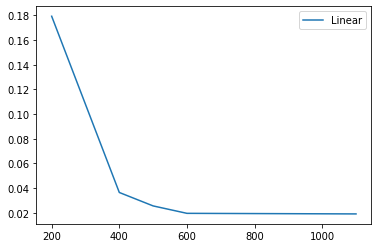

In [41]:
sp_MTPL = interpolate.splrep(mtpl_df['Ret'], mtpl_df['RoP'], k = 1)
x_MTPL = np.linspace(min(mtpl_df['Ret'])-100, max(mtpl_df['Ret'])+100, 100)
pred_MTPL = interpolate.splev(x_MTPL, sp_MTPL, der=0)
MTPL_result = pd.DataFrame(data=[x_MTPL, pred_MTPL]).transpose()
MTPL_result.columns = ["x","y"]

plt.figure('MTPL Rate on Premium')
plt.plot(x_MTPL, pred_MTPL)
plt.legend(['Linear'])
plt.show()

#### MOD Spline for RI Premium

In [42]:
sp_MOD = interpolate.splrep(MOD_df['Ret'] + 0.0, MOD_df['RoP'] + 0.0, k = 1)
x_MOD = np.linspace(min(MOD_df['Ret']) - 200, max(MOD_df['Ret']) + 100, 100)
pred_MOD = interpolate.splev(x_MOD, sp_MOD, der=0)
MOD_result = pd.DataFrame(data = [x_MOD, pred_MOD]).transpose()
MOD_result.columns = ["x","y"]

plt.figure('MOD CAT Rate on Premium')
plt.plot(x_MOD, pred_MOD)
plt.legend(['Linear'])
plt.show()

NameError: name 'MOD_df' is not defined

### Define Optimization Function
#### 1. Realization class

In [43]:
class Realization:
    """
    This class is to get information from strips (realization)
    """
    def __init__(self, n_year, df):
        self.n_year = n_year
        self.df = df
    
    def get_loss(self):
        return(self.df['value'])
    
    def get_year(self):
        return(self.df['realization'])
    
    def gross_loss(self):
        gr_loss =[]
        for i in range(1,self.n_year+1):
            loss = sum(self.df[self.df['realization']==i].iloc[:,1])
            gr_loss.append(loss)
        return(gr_loss)

#### 2. Exl class

In [44]:
class Exl:
    """
    This class is to return ceded loss and reinstatement premium from ELC layer
    """
    def __init__(self, Reinstatement, retention, limit, realization):
        self.Reinstatement = Reinstatement
        self.retention = retention
        self.limit = limit
        self.realization = realization
    
    def net_loss(self,loss):
        """
        This function takes an input as each losses per simulation year and
        returns ceded loss and reinstatement premium.
        """
        if len(loss) == 0:
            a = [0]
            b = [0]
            c = (a,b)
            return(list(c))
        else:
            rein_n = 1
            ceded_loss = []
            rein_add_premium = []
            reinstatement0 = [self.Reinstatement, ['exhausted']]
            reinstatement = list(chain(*reinstatement0))
            
            for i in range(len(loss)):
                flag_reinstatement = str(reinstatement[rein_n-1])
                
                if flag_reinstatement == 'exhausted':
                    L = min(self.limit-self.retention,max(loss[i]-self.retention, 0))
                    if L + sum(ceded_loss) > (rein_n)*(self.limit-self.retention):
                        L = (rein_n)*(self.limit-self.retention) - sum(ceded_loss) 
                    else: L = L
                    ceded_loss.append(L)
                    if sum(ceded_loss) >= (rein_n)*(self.limit-self.retention): rein_n = rein_n + 1
                elif flag_reinstatement == 'amount':
                    L = min(self.limit-self.retention,max(loss[i]-self.retention, 0))
                    ceded_loss.append(L)
                    if sum(ceded_loss) >= (rein_n)*(self.limit-self.retention): rein_n = rein_n + 1
          
                #elif flag_reinstatement == 'time':
                ## not implemented !
          
                elif flag_reinstatement == 'free':
                    L = min(self.limit-self.retention, max(loss[i]-self.retention, 0))
                    ceded_loss.append(L)
                    if sum(ceded_loss) >= (rein_n)*(self.limit-self.retention): rein_n = rein_n + 1
          
                elif flag_reinstatement == 'NULL':
                    ceded_loss.append(0)
          
                else: print("reinstatement type is invalid !")
        
            ## calculation of reinstatements
            cum_loss = np.cumsum(ceded_loss)
            rein_add_premium = []
            for i in range(rein_n, 0, -1):
                res_loss = cum_loss - (i-1) * (self.limit-self.retention)
                reinstatement_i = max(max(res_loss), 0)#maxのdefaultを0とした
                cum_loss = cum_loss - reinstatement_i
                rein_add_premium.append(np.where(reinstatement[i-1] == 'amount', 
                                                 reinstatement_i / (self.limit-self.retention) , 0))

        
        return(ceded_loss, sum(rein_add_premium))
    
    def net_loss_total(self):
        """
        This function returns net loss for each simulation years.
        """
        
        year = self.realization.get_year()
        n_year = self.realization.n_year
        loss = self.realization.get_loss()
        
        div_loss = []
        for i in range(1,n_year+1):#rangeは最後の数値を含まないので、+1する。
            loss_tmp = loss[year==i]
            div_loss.append(loss_tmp)
        
        net_loss_out = []
        for i in range(len(div_loss)):
            nl1 = self.net_loss(list(div_loss[i]))
            net_loss_out.append(nl1)
        return(net_loss_out)
        
    
    ## input : net_loss_total output
    ## ourput : total ceded loss, reinstatements
    ## -------- NOTE!! --------
    ## reinstatements unit is ceded loss.
    ## In case of calculating reinstatements fraction,
    ## use result_frac method.
    def result(self):
        """
        This function returns the final ceded loss and reinstatement premium
        for optimization.
        """
      
        net_loss_t = self.net_loss_total()
        n_year = len(net_loss_t)
      
        ceded_loss = []
        rein_add_pre0 = []
      
        for i in range(n_year):
            ceded_loss.append(sum((net_loss_t[i][0])))
            rein_add_pre0.append(net_loss_t[i][1])
        
        rein_add_pre1 = []
        for i in range(len(rein_add_pre0)):
            if type(rein_add_pre0[i]) == list:
                rein_add_pre1.append(0)
            else:
                rein_add_pre1.append(rein_add_pre0[i])
        
        rein_add_pre = []
        for i in range(n_year):
            rein_add_pre.append(rein_add_pre1[i])
            

        return([ceded_loss, rein_add_pre])
    
    ## reinstatements premium is calculated.
    def result_frac(self):
      
        net_loss_t = self.net_loss_total()
        n_year = len(net_loss_t)
      
        ceded_loss = []
        rein_add_pre0 = []
      
        for i in range(n_year):
            ceded_loss.append(sum((net_loss_t[i][0])))
            rein_add_pre0.append(net_loss_t[i][1])
        
        rein_add_pre1 = []
        for i in range(len(rein_add_pre0)):
            if type(rein_add_pre0[i]) == list:
                rein_add_pre1.append(0)
            else:
                rein_add_pre1.append(rein_add_pre0[i])
        
        rein_add_pre = []
        for i in range(n_year):
        #    ceded_loss.append(sum((net_loss_t[i][0])))
            rein_add_pre.append(rein_add_pre1[i]/( self.limit - self.retention ))
    
    
        return([ceded_loss, rein_add_pre])
        

# Starting Optimization from MTPL ELC
#### (MOD CAT optimization will be executed after MTPL)

####  1 Get MTL_gross_loss from  Realization class

In [45]:
n_year = max(rea_mtl['realization'])
rea1 = Realization(n_year = n_year, df = rea_mtl)
MTL_gross_loss = rea1.gross_loss() #use Realization class to summarize loss data

#### 2. function of Profit and Loss calculator ver1

In [46]:
def MTL_PL(GNPI, RI_Premium, gross_loss, ceded_loss, reinstatements):
    """
    This function takes following input and returns output
    --- INPUT ---
    GNI : Gross Net Premium Income
    RI_Premium : list of Reinsurance premium (e.g c(RI1, RI2, RI3, ... ))
    gross_loss : gross loss realization
    ceded_loss : data.frame of ceded_loss realization
    reinstatements : data.frame of reinstatements fraction realization
    --- OUTPUT ---
    NP : Net Premium
    NL : Net Loss
    NR : Net Return
    CashOut : Gross_Loss - Ceded_Loss + Reinstatements + ReInsurance_Premium
    RI_premium : Reinsurance Premium of all schemes
    N_LR : Net Loss Ratio
    AVG Ceded Loss
    AVG Reinstatement Premium
    AVG Gross Loss
    AVG Net Loss
    Gross Loss Ratio
    Ceded Loss Ratio
    """
     
    n_contracts = len(ceded_loss)
    n_year = len(gross_loss)
  
    GNPI_l = np.repeat(GNPI, n_year)
    RI_Premium_l = np.repeat(sum(RI_Premium), n_year)
    ceded_loss_l = ceded_loss.apply(np.sum,1)
    reinstatements_l = reinstatements.apply(np.sum, 1)
    
    gross_loss = gross_loss + aty_exp['aty_exp'] #add expense to gross loss. expense is output of Remetrica workbook
    NP = np.mean(GNPI_l - RI_Premium_l - reinstatements_l) * (1-QS_RATE) #Net of QS
    NL = (gross_loss - ceded_loss_l) * (1-QS_RATE) #Net of QS
    NR = (GNPI_l - RI_Premium_l - reinstatements_l - (gross_loss - ceded_loss_l)) * (1-QS_RATE) 
    CashOut = RI_Premium_l + reinstatements_l + (gross_loss - ceded_loss_l) * (1-QS_RATE) #Expense added
    if np.mean(NL) == 0: N_LR = 0
    else: N_LR = np.mean(NL)/np.mean(NP)
    if np.mean(gross_loss) == 0: G_LR = 0
    else: G_LR = np.mean(gross_loss)/np.mean(GNPI_l)
    if np.mean(ceded_loss_l) == 0: C_LR = 0
    else: C_LR = np.mean(ceded_loss_l)/np.mean((RI_Premium_l + reinstatements_l))
    
    #For Premium STEC
    att_aty_net_prem = aty_exp['att_aty_net_prem']
    att_aty_net_exp = aty_exp['att_aty_net_exp']
    att_net_loss = aty_exp['att_net_loss']
    #New ATT&ATY Net Result Strip, based on retention level
    att_aty_net_result = att_aty_net_prem - att_aty_net_exp - (att_net_loss + NL)
    
    #Portfolio STEC
    MOH_Port_Mean, MOH_Port_STEC = sort_func(MOH_Port_Str,'ascending')[0], -sort_func(MOH_Port_Str,'ascending')[1]
    MTL_Port_Mean, MTL_Port_STEC = sort_func(MTL_Port_Str,'ascending')[0], -sort_func(MTL_Port_Str,'ascending')[1]
    PAC_Port_Mean, PAC_Port_STEC = sort_func(PAC_Port_Str,'ascending')[0], -sort_func(PAC_Port_Str,'ascending')[1]

    Total_Port_Mean = MOH_Port_Mean + MTL_Port_Mean + PAC_Port_Mean

    #VaR calibration for Lognormal simulation
    STEC_list_Port = [MOH_Port_STEC, MTL_Port_STEC, PAC_Port_STEC]
    STEC_Port = pd.DataFrame(STEC_list_Port,columns=['STEC_Portfolio'])
    #Run Simulation
    sim_result = STEC_Simulation(
                            np.array(df_corr.iloc[:,1:]),
                            STEC_Port,
                            Total_Port_Mean,
                            0, #Portfolio Mean, used for only Premium STEC
                        )
    Total_Port_STEC_Fin = sim_result[0]

    #Premium STEC
    MOH_Prem_UPR_Str = MOH_Prem_Str + MOH_UPR_Vola
    MTL_Prem_UPR_Str = att_aty_net_result + MTL_UPR_Vola #MTL ATT&ATY Net Result Strip is replaced by new amount
    PAC_Prem_UPR_Str = PAC_Prem_Str + PAC_UPR_Vola

    MOH_Prem_Mean, MOH_Prem_STEC = sort_func(MOH_Prem_UPR_Str,'ascending')[0], -sort_func(MOH_Prem_UPR_Str,'ascending')[1]
    MTL_Prem_Mean, MTL_Prem_STEC = sort_func(MTL_Prem_UPR_Str,'ascending')[0], -sort_func(MTL_Prem_UPR_Str,'ascending')[1]
    PAC_Prem_Mean, PAC_Prem_STEC = sort_func(PAC_Prem_UPR_Str,'ascending')[0], -sort_func(PAC_Prem_UPR_Str,'ascending')[1]

    Tot_Prem_Mean = MOH_Prem_Mean + MTL_Prem_Mean + PAC_Prem_Mean

    #Total (Portfolio - Premium)
    Total_Prem_Mean =  Total_Port_Mean-Tot_Prem_Mean

    #VaR calibration for Lognormal simulation
    STEC_list = [MOH_Prem_STEC, MTL_Prem_STEC, PAC_Prem_STEC]
    STEC_Prem = pd.DataFrame(STEC_list,columns=['STEC_Premium'])
    #Run Simulation
    sim_result = STEC_Simulation(
                            np.array(df_corr.iloc[:,1:]),
                            STEC_Prem,
                            Total_Prem_Mean,
                            Total_Port_Mean, #Portfolio Mean, used for only Premium STEC
                        )
    Total_Prem_STEC_Fin = sim_result[0]
    Total_Prem_STEC_Rank = STEC_Ranking(df_prem_rank,sim_result[1],'ascending')
    #Total P&C STEC
    Total_STEC_Strip = (np.array(Total_Res_STEC_Rank)+np.array(Total_Prem_STEC_Rank)+np.array(MOH_CAT_Str))
    Total_STEC_Strip_Mean, PC_STEC = sort_func(Total_STEC_Strip,'descending')
  
    return([
            NP, #0 Net Premium
            NL, #1 Net Loss
            NR, #2 Net Return
            CashOut, #3 Cash Out
            np.mean(RI_Premium_l), #4 RI Premium
            N_LR, #5 Net LR
            np.mean(ceded_loss_l), #6 AVGCeded Loss
            np.mean(reinstatements_l), #7 Reinstatement Premium
            np.mean(gross_loss), #8 AVG Gross Loss
            np.mean(NL), #9 AVG Net Loss
            G_LR, #10 AVG Gross Loss Ratio
            C_LR, #11 AVG Ceded Loss Ratio
            PC_STEC, #12 Total P&C STEC
            ]) 

### 3. Define object function
#### 3.1 Object Function for Cash Out

In [47]:
def MTL_obj_func(ret_opt):
    """
    This function is for reinsurance retention optimization based on net cash flow.
    """
  
    ## estimating 1st layer Reinsurance Premium
    ## from 200000000 to 1000000000
  
    pred_ex1_p = interpolate.splev(float(ret_opt)/1000000, sp_MTPL, der=0) * MTL_GNPI
    pred_ex1_p = (pred_ex1_p - MTL_GNPI * MTL_RoP2)/100
  
    RIP_opt = [pred_ex1_p, MTL_RIP[1], MTL_RIP[2], MTL_RIP[3]]
  
    ## Layer construction
    ex1 = Exl(Reinstatement=['free', 'free', 'amount'],
                 retention= float(ret_opt),
                 limit=1000000000,
                 realization=rea1)
  
    ex2 = Exl(Reinstatement=['free', 'free', 'amount'],
                 retention=1000000000,
                 limit=6000000000,
                 realization=rea1)
  
    ex3 = Exl(Reinstatement=['free', 'free', 'amount'],
                 retention=6000000000,
                 limit=10550000000,
                 realization=rea1)
  
    ex4 = Exl(Reinstatement=['free', 'free', 'amount'],
                 retention=10550000000,
                 limit=1000000000000,
                 realization=rea1)
  
    # result()
    ex1_result = pd.DataFrame(ex1.result()).transpose()
    ex1_result.columns = ['ex1_ceded', 'ex1_reins']
    ex2_result = pd.DataFrame(ex2.result()).transpose()
    ex2_result.columns = ['ex2_ceded', 'ex2_reins']
    ex3_result = pd.DataFrame(ex3.result()).transpose()
    ex3_result.columns = ['ex3_ceded', 'ex3_reins']
    ex4_result = pd.DataFrame(ex4.result()).transpose()
    ex4_result.columns = ['ex4_ceded', 'ex4_reins']
    # result_frac()
    #ex1_result = pd.DataFrame(ex1.result_frac()).transpose()
    #ex1_result.columns = ['ex1_ceded', 'ex1_reins']
    #ex2_result = pd.DataFrame(ex2.result_frac()).transpose()
    #ex2_result.columns = ['ex2_ceded', 'ex2_reins']
    #ex3_result = pd.DataFrame(ex3.result_frac()).transpose()
    #ex3_result.columns = ['ex3_ceded', 'ex3_reins']
    #ex4_result = pd.DataFrame(ex4.result_frac()).transpose()
    #ex4_result.columns = ['ex4_ceded', 'ex4_reins']

    ceded_loss_df = pd.DataFrame([ex1_result['ex1_ceded'],
                                ex2_result['ex2_ceded'],
                                ex3_result['ex3_ceded'],
                                ex4_result['ex4_ceded']]).transpose()
    ceded_loss_df.columns = ['ex1', 'ex2', 'ex3', 'ex4']
    
    reins_df = pd.DataFrame([ex1_result['ex1_reins']*pred_ex1_p,
                           ex2_result['ex2_reins']*MTL_RIP[1],
                           ex3_result['ex3_reins']*MTL_RIP[2],
                           ex4_result['ex4_reins']*MTL_RIP[3]]).transpose()
    reins_df.columns = ['ex1', 'ex2', 'ex3', 'ex4']
  
  
    ## Calculation of Net Underwriting Return in current Reinsurance scheme
    NetUWP = MTL_PL(GNPI = MTL_GNPI,#GNPI_PL_analysis,
                 RI_Premium = RIP_opt,
                 gross_loss = MTL_gross_loss,
                 ceded_loss = ceded_loss_df,
                 reinstatements = reins_df)
  
    return(np.mean(NetUWP[3]))


#### 3.2 Object Function for Return on STEC

In [48]:
def MTL_obj_func_RoSTEC(ret_opt):
    """
    This function is for reinsurance retention optimization based on return on STEC.
    """
  
    ## estimating 1st layer Reinsurance Premium
    ## from 200000000 to 1000000000
  
    pred_ex1_p = interpolate.splev(float(ret_opt)/1000000, sp_MTPL, der=0) * MTL_GNPI
    pred_ex1_p = (pred_ex1_p - MTL_GNPI * MTL_RoP2)/100
  
    RIP_opt = [pred_ex1_p, MTL_RIP[1], MTL_RIP[2], MTL_RIP[3]]
  
    ## Layer construction
    ex1 = Exl(Reinstatement=['free', 'free', 'amount'],
                 retention=float(ret_opt),
                 limit=1000000000,
                 realization=rea1)
  
    ex2 = Exl(Reinstatement=['free', 'free', 'amount'],
                 retention=1000000000,
                 limit=6000000000,
                 realization=rea1)
  
    ex3 = Exl(Reinstatement=['free', 'free', 'amount'],
                 retention=6000000000,
                 limit=10550000000,
                 realization=rea1)
  
    ex4 = Exl(Reinstatement=['free', 'free', 'amount'],
                 retention=10550000000,
                 limit=1000000000000,
                 realization=rea1)
  
    # result()
    ex1_result = pd.DataFrame(ex1.result()).transpose()
    ex1_result.columns = ['ex1_ceded', 'ex1_reins']
    ex2_result = pd.DataFrame(ex2.result()).transpose()
    ex2_result.columns = ['ex2_ceded', 'ex2_reins']
    ex3_result = pd.DataFrame(ex3.result()).transpose()
    ex3_result.columns = ['ex3_ceded', 'ex3_reins']
    ex4_result = pd.DataFrame(ex4.result()).transpose()
    ex4_result.columns = ['ex4_ceded', 'ex4_reins']
    # result_frac()
    #ex1_result = pd.DataFrame(ex1.result_frac()).transpose()
    #ex1_result.columns = ['ex1_ceded', 'ex1_reins']
    #ex2_result = pd.DataFrame(ex2.result_frac()).transpose()
    #ex2_result.columns = ['ex2_ceded', 'ex2_reins']
    #ex3_result = pd.DataFrame(ex3.result_frac()).transpose()
    #ex3_result.columns = ['ex3_ceded', 'ex3_reins']
    #ex4_result = pd.DataFrame(ex4.result_frac()).transpose()
    #ex4_result.columns = ['ex4_ceded', 'ex4_reins']

    ceded_loss_df = pd.DataFrame([ex1_result['ex1_ceded'],
                                ex2_result['ex2_ceded'],
                                ex3_result['ex3_ceded'],
                                ex4_result['ex4_ceded']]).transpose()
    ceded_loss_df.columns = ['ex1', 'ex2', 'ex3', 'ex4']
    
    reins_df = pd.DataFrame([ex1_result['ex1_reins']*pred_ex1_p,
                           ex2_result['ex2_reins']*MTL_RIP[1],
                           ex3_result['ex3_reins']*MTL_RIP[2],
                           ex4_result['ex4_reins']*MTL_RIP[3]]).transpose()
    reins_df.columns = ['ex1', 'ex2', 'ex3', 'ex4']
  
  
    ## Calculation of Net Underwriting Return in current Reinsurance scheme
    NetUWP = MTL_PL(GNPI = MTL_GNPI,#GNPI_PL_analysis,
                 RI_Premium = RIP_opt,
                 gross_loss = MTL_gross_loss,
                 ceded_loss = ceded_loss_df,
                 reinstatements = reins_df)
    
    df1 = pd.DataFrame(NetUWP[1],columns = ["cashout"]).sort_values(by="cashout",ascending=False)
    top50 = df1.iloc[249]
    avg1 = np.mean(df1)
    #STEC calculation
    STEC = top50 - avg1
    MVM = STEC * 0.06
    Exp_Rec = NetUWP[6]
    RI_Prem = NetUWP[4]
    Reins_Prem = NetUWP[7]
    #Net Return is calculated by PL function above.
    Net_Return = np.mean(NetUWP[2])
    PC_Value = Exp_Rec - RI_Prem - Reins_Prem- MVM
    #Return on STEC calculation
    RoSTEC = Net_Return / STEC
    #P&C Underlying Earning on P&C STEC calculation
    net_return_move = Net_Return - current_net_return
    new_pc_ue = PC_UE + net_return_move
    pc_ue_on_stec = new_pc_ue / NetUWP[12]
    
    return np.array(-pc_ue_on_stec) #Underlying Earnings on STEC
    #return(np.mean(-RoSTEC)) #python opt func minimize the result.  Thus, changing signs of RoSTEC from pos to neg


#### 3.3 Object Function for P&C Value

In [49]:
def MTL_obj_func_pcvalue(ret_opt):
    """
    This function is for reinsurance retention optimization based on P&C Value.
    P&C Value = expected recovery - RI premium - reinstatement premium - MVM.
    """
    pred_ex1_p = interpolate.splev(float(ret_opt)/1000000, sp_MTPL, der=0) * MTL_GNPI
    pred_ex1_p = (pred_ex1_p - MTL_GNPI * MTL_RoP2)/100
  
    RIP_opt = [pred_ex1_p, MTL_RIP[1], MTL_RIP[2], MTL_RIP[3]]
  
    ## Layer construction
    ex1 = Exl(Reinstatement=['free', 'free', 'amount'],
                 retention=float(ret_opt),
                 limit=1000000000,
                 realization=rea1)
  
    ex2 = Exl(Reinstatement=['free', 'free', 'amount'],
                 retention=1000000000,
                 limit=6000000000,
                 realization=rea1)
  
    ex3 = Exl(Reinstatement=['free', 'free', 'amount'],
                 retention=6000000000,
                 limit=10550000000,
                 realization=rea1)
  
    ex4 = Exl(Reinstatement=['free', 'free', 'amount'],
                 retention=10550000000,
                 limit=1000000000000,
                 realization=rea1)
  
    # result()
    ex1_result = pd.DataFrame(ex1.result()).transpose()
    ex1_result.columns = ['ex1_ceded', 'ex1_reins']
    ex2_result = pd.DataFrame(ex2.result()).transpose()
    ex2_result.columns = ['ex2_ceded', 'ex2_reins']
    ex3_result = pd.DataFrame(ex3.result()).transpose()
    ex3_result.columns = ['ex3_ceded', 'ex3_reins']
    ex4_result = pd.DataFrame(ex4.result()).transpose()
    ex4_result.columns = ['ex4_ceded', 'ex4_reins']
    # result_frac()
    #ex1_result = pd.DataFrame(ex1.result_frac()).transpose()
    #ex1_result.columns = ['ex1_ceded', 'ex1_reins']
    #ex2_result = pd.DataFrame(ex2.result_frac()).transpose()
    #ex2_result.columns = ['ex2_ceded', 'ex2_reins']
    #ex3_result = pd.DataFrame(ex3.result_frac()).transpose()
    #ex3_result.columns = ['ex3_ceded', 'ex3_reins']
    #ex4_result = pd.DataFrame(ex4.result_frac()).transpose()
    #ex4_result.columns = ['ex4_ceded', 'ex4_reins']

    ceded_loss_df = pd.DataFrame([ex1_result['ex1_ceded'],
                                ex2_result['ex2_ceded'],
                                ex3_result['ex3_ceded'],
                                ex4_result['ex4_ceded']]).transpose()
    ceded_loss_df.columns = ['ex1', 'ex2', 'ex3', 'ex4']
    
    reins_df = pd.DataFrame([ex1_result['ex1_reins']*pred_ex1_p,
                           ex2_result['ex2_reins']*MTL_RIP[1],
                           ex3_result['ex3_reins']*MTL_RIP[2],
                           ex4_result['ex4_reins']*MTL_RIP[3]]).transpose()
    reins_df.columns = ['ex1', 'ex2', 'ex3', 'ex4']
  
  
    ## Calculation of Net Underwriting Return in current Reinsurance scheme
    NetUWP = MTL_PL(GNPI = MTL_GNPI,#GNPI_PL_analysis,
                 RI_Premium = RIP_opt,
                 gross_loss = MTL_gross_loss,
                 ceded_loss = ceded_loss_df,
                 reinstatements = reins_df)
    
    df1 = pd.DataFrame(NetUWP[1],columns = ["cashout"]).sort_values(by="cashout",ascending=False)
    top50 = df1.iloc[249]
    avg1 = np.mean(df1)
    STEC = top50 - avg1
    MVM = STEC * 0.06
    Exp_Rec = NetUWP[6]
    RI_Prem = NetUWP[4]
    Reins_Prem = NetUWP[7]
    Net_Return = np.mean(NetUWP[2])
    #P&C Value calculation
    PC_Value = Exp_Rec - RI_Prem - Reins_Prem- MVM
    RoSTEC = Net_Return / STEC
  
    return(np.mean(-PC_Value)) #P&C Value is negative generally, but it should be maximized.  Thus chaning sign.


#### Stats Function

In [50]:
def MTL_obj_func_stats(ret_opt):
    """
    This function is for summary statistics of optimization.
    """
      
    pred_ex1_p = interpolate.splev(float(ret_opt)/1000000, sp_MTPL, der=0) * MTL_GNPI
    pred_ex1_p = (pred_ex1_p - MTL_GNPI * MTL_RoP2)/100
  
    RIP_opt = [pred_ex1_p, MTL_RIP[1], MTL_RIP[2], MTL_RIP[3]]
  
    ## Layer construction
    ex1 = Exl(Reinstatement=['free', 'free', 'amount'],
                 retention=float(ret_opt),
                 limit=1000000000,
                 realization=rea1)
  
    ex2 = Exl(Reinstatement=['free', 'free', 'amount'],
                 retention=1000000000,
                 limit=6000000000,
                 realization=rea1)
  
    ex3 = Exl(Reinstatement=['free', 'free', 'amount'],
                 retention=6000000000,
                 limit=10550000000,
                 realization=rea1)
  
    ex4 = Exl(Reinstatement=['free', 'free', 'amount'],
                 retention=10550000000,
                 limit=1000000000000,
                 realization=rea1)
  
    # result()
    ex1_result = pd.DataFrame(ex1.result()).transpose()
    ex1_result.columns = ['ex1_ceded', 'ex1_reins']
    ex2_result = pd.DataFrame(ex2.result()).transpose()
    ex2_result.columns = ['ex2_ceded', 'ex2_reins']
    ex3_result = pd.DataFrame(ex3.result()).transpose()
    ex3_result.columns = ['ex3_ceded', 'ex3_reins']
    ex4_result = pd.DataFrame(ex4.result()).transpose()
    ex4_result.columns = ['ex4_ceded', 'ex4_reins']

    ceded_loss_df = pd.DataFrame([ex1_result['ex1_ceded'],
                                ex2_result['ex2_ceded'],
                                ex3_result['ex3_ceded'],
                                ex4_result['ex4_ceded']]).transpose()
    ceded_loss_df.columns = ['ex1', 'ex2', 'ex3', 'ex4']
    
    reins_df = pd.DataFrame([ex1_result['ex1_reins']*pred_ex1_p,
                           ex2_result['ex2_reins']*MTL_RIP[1],
                           ex3_result['ex3_reins']*MTL_RIP[2],
                           ex4_result['ex4_reins']*MTL_RIP[3]]).transpose()
    reins_df.columns = ['ex1', 'ex2', 'ex3', 'ex4']
  
    ## Calculation of Net Underwriting Return in current Reinsurance scheme
    NetUWP = MTL_PL(GNPI = MTL_GNPI,#GNPI_PL_analysis,
                 RI_Premium = RIP_opt,
                 gross_loss = MTL_gross_loss,
                 ceded_loss = ceded_loss_df,
                 reinstatements = reins_df)
    
    CashOut_Strip = pd.DataFrame(NetUWP[1],columns = ["cashout"]).sort_values(by="cashout",ascending=False)
    var995 = CashOut_Strip.iloc[249]
    var95 = CashOut_Strip.iloc[2499]
    median = CashOut_Strip.iloc[24999]
    avg1 = np.mean(CashOut_Strip)
    max1 = np.max(CashOut_Strip)
    min1 = np.min(CashOut_Strip)
    std = np.std(CashOut_Strip)
    STEC = var995 - avg1
    MVM = NetUWP[12] * 0.06 #STEC * 0.06
    Exp_Rec = NetUWP[6]
    RI_Prem = NetUWP[4]
    Reins_Prem = NetUWP[7]
    Net_Return = np.mean(NetUWP[2])
    PC_Value = Exp_Rec - RI_Prem - Reins_Prem- MVM
    RoSTEC = Net_Return / STEC
    #RoSTEC = NetUWP[13]
    Gross_Loss = NetUWP[8]
    Net_Loss = NetUWP[9]
    Gross_LR = NetUWP[10]
    Net_LR = NetUWP[5]
    Ceded_LR = NetUWP[11]
    CashOut = np.mean(NetUWP[3])
    Net_Loss_Strip = NetUWP[1]
    PC_Shock_20yr = var95 - avg1
    #For P&C UE on P&C STEC calc
    PC_STEC = NetUWP[12]
    try:
        net_return_move = Net_Return - current_net_return
    except:
        net_return_move = 0
    new_pc_ue = PC_UE + net_return_move
    pc_ue_on_stec = new_pc_ue / PC_STEC
  
    return(CashOut_Strip,#0 
           var995, #1
           var95, #2
           median, #3
           avg1, #4
           STEC, #5
           MVM, #6
           Exp_Rec,#7
           RI_Prem, #8
           Reins_Prem,#9 
           Net_Return, #10
           PC_Value, #11
           RoSTEC, #12
           MTL_GNPI,#13
           max1,#14
           min1,#15
           std, #16
           Gross_Loss, #17
           Net_Loss, #18
           Gross_LR, #19
           Net_LR, #20
           Ceded_LR, #21
           CashOut, #22
           Net_Loss_Strip, #23
           PC_Shock_20yr, #24
           PC_STEC, #25
           new_pc_ue, #26
           pc_ue_on_stec, #27
          )

### 4. Run Optimization Function

In [51]:
def MTL_opt(obj_func, bounds, method):
    """
    This function executes optimization.
    Input takes type of object function, optimization bounday, and method of optimization (bounded)
    Returns optimization result and dataframe for a graph
    """
    #Execute optimization function (minimize_scalar)
    opt_res = minimize_scalar(obj_func, bounds=bounds, method=method)
    gpar = list(np.linspace(200000000, 999999999, 10))
    gpar.append(opt_res.x)
    #Get target value by different retentions
    obj_res = [obj_func(i) for i in gpar]
    df_obj = pd.DataFrame({
    'ret': gpar,
    'obj_res': obj_res,
    })
    df_obj = df_obj.sort_values(by='ret')

    return(opt_res, df_obj)

#### Stats for Current Retention

In [52]:
MTL_Current_Stats = MTL_obj_func_stats(MTL_CUR_RET)
MTL_res_cur = [MTL_CUR_RET,pd.DataFrame({
    'obj_res':[MTL_CUR_RET],
    'ret':[MTL_CUR_RET]})]
current_net_return = MTL_Current_Stats[10]

In [53]:
MTL_Current_Stats[25] # P&C STEC

8327464157.5552406

#### 4.1 Cash out Optimization

In [54]:
MTL_res_CashOut = MTL_opt(MTL_obj_func, BOUND, 'bounded')
MTL_CashOut_Stats = MTL_obj_func_stats(MTL_res_CashOut[1][MTL_res_CashOut[1]['obj_res']==
                                                          min(MTL_res_CashOut[1]['obj_res'])]['ret'])

In [55]:
MTL_res_CashOut[1].to_csv("MTL_CashOut_Result_for_graph_3_Toa_quatation.csv")

#### 4.2 Return on STEC Optimization

In [56]:
MTL_res_RoSTEC = MTL_opt(MTL_obj_func_RoSTEC, BOUND, 'bounded')
MTL_RoSTEC_Stats = MTL_obj_func_stats(MTL_res_RoSTEC[1][MTL_res_RoSTEC[1]['obj_res']==
                                                        float(min(MTL_res_RoSTEC[1]['obj_res']))]['ret'])

In [57]:
MTL_res_RoSTEC[1].to_csv("MTL_RoSTEC_Result_for_graph_3_Toa_quatation.csv")

#### 4.3 P&C Value Optimization

### P&C ValueはAGD独自の指標だったこともあり不要とした
MTL_res_pcvalue = MTL_opt(MTL_obj_func_pcvalue, BOUND, 'bounded')
MTL_PCValue_Stats = MTL_obj_func_stats(MTL_res_pcvalue[1][MTL_res_pcvalue[1]['obj_res']==
                                                          min(MTL_res_pcvalue[1]['obj_res'])]['ret'])

In [58]:
#additional retentions for reference
MTL_sl = []
for i in MTL_ADD_RET:
    cs = MTL_obj_func_stats(i)
    rs = [i,pd.DataFrame({
    'obj_res':[i],
    'ret':[i]})]
    tup = (cs,rs)
    MTL_sl.append(tup)

In [ ]:
MTL_stats_fun(tup_test[1], tup_test[0], 'Retention: 700m')

### 5. Summary

In [59]:
def MTL_stats_fun(res_type, stats_type, opt_type):
    """
    This function makes a summary table for optimization result.
    Input takes optimization result, summary stats by optimization type, and string for name of output
    """
    df = pd.DataFrame({
    '(00) Retention':"{:,.1f}".format(float(res_type[1][res_type[1]['obj_res']==
                                                        float(min(res_type[1]['obj_res']))]['ret']/10**6)),
    '(01) Median (Strip)':"{:,.1f}".format(float(stats_type[3]/10**6)),
    '(02) Mean (Strip)':"{:,.1f}".format(float(stats_type[4]/10**6)),
    '(03) Standard Deviation (Strip)':"{:,.1f}".format(float(stats_type[16]/10**6)),
    '(04) Max (Strip)':"{:,.1f}".format(float(stats_type[14]/10**6)),
    '(05) Min (Strip)':"{:,.1f}".format(float(stats_type[15]/10**6)),
    "(06) VaR 95 (Strip)":"{:,.1f}".format(float(stats_type[2]/10**6)),
    "(07) VaR 99.5 (Strip)":"{:,.1f}".format(float(stats_type[1]/10**6)),
    "(08) 20yr P&C Shock (VaR95 - Mean)":"{:,.1f}".format(float(stats_type[24]/10**6)),
    "(09) Atypical STEC (VaR99.5 - Mean)":"{:,.1f}".format(float(stats_type[5]/10**6)),
    "(10) Cost of Capital (6% of Atypical STEC)":"{:,.1f}".format(float(stats_type[6]/10**6)),
    "(11) Gross Loss":"{:,.1f}".format(float(stats_type[17]/10**6)),
    "(12) Net Loss":"{:,.1f}".format(float(stats_type[18]/10**6)),
    "(13) Expected Recovery (Ceded Loss)":"{:,.1f}".format(float(stats_type[7]/10**6)),
    "(14) MTPL GWP":"{:,.1f}".format(float(stats_type[13]/10**6)),
    "(15) Reinsurance Premium":"{:,.1f}".format(float(stats_type[8]/10**6)),
    "(16) Reinstatement Premium":"{:,.1f}".format(float(stats_type[9]/10**6)),
    "(17) Gross LR":["{:.3%}".format(float(stats_type[19]))],
    "(18) Net LR":["{:.3%}".format(float(stats_type[20]))],
    "(19) Ceded LR":["{:.3%}".format(float(stats_type[21]))],
    "(20) P&C Underlying Earnings":"{:,.3f}".format(float(stats_type[26]/10**6)),
    "(21) P&C STEC":"{:,.3f}".format(float(stats_type[25]/10**6)),
    "(22) Net Cash Out (RI Premium + Reinst Premium + Net Loss + Expense)":"{:,.6f}".format(float(stats_type[22]/10**6)),
    #"(21) Net Return (MTPL GWP - RI Prem - Reinst Prem - Net Loss - Expense)":"{:,.1f}".format(float(stats_type[26]/10**6)),
    "(23) Return on STEC (P&C UE / P&C STEC)":["{:.6%}".format(float(stats_type[27]))],
    "(24) P&C Value (Exp Rec - RI Prem - Reins Prem- CoC)":"{:,.1f}".format(float(stats_type[11]/10**6)),
    })
    df = df.transpose()
    df.columns = [opt_type]
    
    return df

In [60]:
#Make dataframes by optimization results
MTL_df_Current = MTL_stats_fun(MTL_res_cur, MTL_Current_Stats, 'Current Retention')
MTL_df_CashOut = MTL_stats_fun(MTL_res_CashOut, MTL_CashOut_Stats, 'CashOut Optimum')
MTL_df_RoSTEC = MTL_stats_fun(MTL_res_RoSTEC, MTL_RoSTEC_Stats, 'RoSTEC Optimum')
#MTL_df_PCValue = MTL_stats_fun(MTL_res_pcvalue, MTL_PCValue_Stats, 'P&C Value Optimum')
MTL_df_300 = MTL_stats_fun(MTL_sl[0][1], MTL_sl[0][0], 'Retention: 300m')
MTL_df_500 = MTL_stats_fun(MTL_sl[1][1], MTL_sl[1][0], 'Retention: 500m')
MTL_df_600 = MTL_stats_fun(MTL_sl[2][1], MTL_sl[2][0], 'Retention: 600m')
MTL_df_999 = MTL_stats_fun(MTL_sl[3][1], MTL_sl[3][0], 'Retention: 999m')
MTL_df_all = MTL_df_Current.join(MTL_df_CashOut).join(MTL_df_RoSTEC).join(MTL_df_300).join(MTL_df_500).join(MTL_df_600).join(MTL_df_999)
MTL_df_all.to_csv('MTL_Summary_Table.csv')

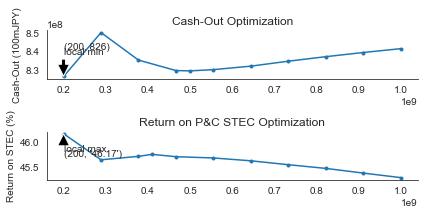

MTPL Summary Table in mJPY
CashOut Optimum Retention: 499999999.261


,Current Retention,CashOut Optimum,RoSTEC Optimum,Retention: 300m,Retention: 500m,Retention: 600m,Retention: 999m
(00) Retention,400.0,200.0,200.0,300.0,500.0,600.0,"1,000.0"
(01) Median (Strip),762.1,708.8,708.8,754.4,764.1,765.2,765.6
(02) Mean (Strip),814.8,752.3,752.3,804.7,819.1,822.7,833.6
(03) Standard Deviation (Strip),447.1,398.9,398.9,436.8,452.9,458.8,482.5
(04) Max (Strip),"3,769.8","3,272.6","3,272.6","3,575.8","3,963.8","4,157.8","4,650.9"
(05) Min (Strip),0.0,0.0,0.0,0.0,0.0,0.0,0.0
(06) VaR 95 (Strip),"1,635.3","1,473.1","1,473.1","1,598.8","1,653.7","1,667.9","1,728.2"
(07) VaR 99.5 (Strip),"2,250.0","2,002.7","2,002.7","2,192.4","2,283.9","2,319.5","2,534.7"
(08) 20yr P&C Shock (VaR95 - Mean),820.4,720.7,720.7,794.1,834.6,845.3,894.5
(09) Atypical STEC (VaR99.5 - Mean),"1,435.1","1,250.3","1,250.3","1,387.8","1,464.8","1,496.9","1,701.0"


<Figure size 432x288 with 0 Axes>

In [61]:
plt.figure('MTPL Reinsurance Retention Optimization')
sns.set_style("white")

x1 = MTL_res_CashOut[1]['ret'] 
x2 = MTL_res_RoSTEC[1]['ret'] 
#x3 = MTL_res_pcvalue[1]['ret'] 

x1_min = MTL_res_CashOut[1][MTL_res_CashOut[1]['obj_res']==min(MTL_res_CashOut[1]['obj_res'])]['ret']
x2_min = MTL_res_RoSTEC[1][MTL_res_RoSTEC[1]['obj_res']==float(min(MTL_res_RoSTEC[1]['obj_res']))]['ret']
#x3_min = MTL_res_pcvalue[1][MTL_res_pcvalue[1]['obj_res']==min(MTL_res_pcvalue[1]['obj_res'])]['ret']

y1 = MTL_res_CashOut[1]['obj_res']
y2 = -MTL_res_RoSTEC[1]['obj_res']*100
#y3 = -MTL_res_pcvalue[1]['obj_res']

y1_min = min(MTL_res_CashOut[1]['obj_res'])
y2_min = max(-MTL_res_RoSTEC[1]['obj_res'])*100
#y3_min = max(-MTL_res_pcvalue[1]['obj_res'])

#Plot1
plt.subplot(3, 1, 1)
plt.plot(x1, y1, '.-')
plt.title('Cash-Out Optimization')
#plt.xlabel('Retention')
plt.ylabel('Cash-Out (100mJPY)')
plt.annotate('local min', xy = (x1_min, y1_min), 
            xytext = (x1_min, y1_min + y1_min/70),
            arrowprops = dict(facecolor = 'black', shrink = 0.01))
plt.annotate((int(x1_min/10**6), int(y1_min/10**6)),
            xy = (x1_min, y1_min), textcoords = 'data',
            xytext = (x1_min, y1_min + y1_min/58))

#Plot2
plt.subplot(3, 1, 2)
plt.plot(x2, y2, '.-')
plt.title('Return on P&C STEC Optimization')
#plt.xlabel('Retention')
plt.ylabel('Return on STEC (%)')
plt.annotate('local max', xy = (x2_min, y2_min), 
            xytext = (x2_min, y2_min - .35),
            arrowprops = dict(facecolor = 'black', shrink = 0.01))
plt.annotate((int(x2_min/10**6), "{:.2f}".format(float(y2_min))),
            xy = (x2_min, y2_min), textcoords = 'data',
            xytext = (x2_min, y2_min - .45))
#Plot3
#plt.subplot(3, 1, 3)
#plt.plot(x3, y3, '.-')
#plt.title('P&C Value Optimization')
#plt.xlabel('Retention (Billion JPY)')
#plt.ylabel('P&C Value (10mJPY)')
#plt.annotate('local max', xy = (x3_min, y3_min), #arrow annotation
#            xytext = (x3_min, y3_min + y3_min/2),
#            arrowprops = dict(facecolor = 'black', shrink = 0.01))
#plt.annotate((int(x3_min/10**6), int(y3_min/10**6)), #coordinates annotation
#            xy = (x3_min, y3_min), textcoords = 'data',
#            xytext = (x3_min, y3_min + y3_min/1.65))
sns.despine()
plt.tight_layout()
plt.show()
plt.savefig('mtl.png', bbox_inches='tight')
print('MTPL Summary Table in mJPY')
print('CashOut Optimum Retention:', MTL_res_CashOut[0].x)#, '\n'
#     'P&C Value Optimum Retention:', np.array(MTL_res_pcvalue[1][MTL_res_pcvalue[1]['obj_res'] == 
#                                                        min(MTL_res_pcvalue[1]['obj_res'])]['ret'])[0])
MTL_df_all

### End of MTPL ELC Optimization

# Starting Optimization from MOD CAT ELC

####  1. Get MOD_gross_loss from  Realization class

In [ ]:
n_year = max(rea_CAT['realization'])
rea1 = Realization(n_year = n_year, df = rea_CAT)
CAT_gross_loss = rea1.gross_loss()
reaEQ = Realization(n_year = n_year, df = rea_EQ) #use Realization class to summarize loss data

#### 2. function of Profit and Loss calculator ver1

In [ ]:
def MOD_PL(GNPI, RI_Premium, gross_loss, ceded_loss, reinstatements):
    """
    This function takes following input and returns output
    --- INPUT ---
    GNI : Gross Net Premium Income
    RI_Premium : list of Reinsurance premium (e.g c(RI1, RI2, RI3, ... ))
    gross_loss : gross loss realization
    ceded_loss : data.frame of ceded_loss realization
    reinstatements : data.frame of reinstatements fraction realization
    --- OUTPUT ---
    NP : Net Premium
    NL : Net Loss
    NR : Net Return
    CashOut : Gross_Loss - Ceded_Loss + Reinstatements + ReInsurance_Premium
    RI_premium : Reinsurance Premium of all schemes
    N_LR : Net Loss Ratio
    AVG Ceded Loss
    AVG Reinstatement Premium
    AVG Gross Loss
    AVG Net Loss
    Gross Loss Ratio
    Ceded Loss Ratio
    """
    n_contracts = len(ceded_loss)
    n_year = len(gross_loss)
  
    GNPI_l = np.repeat(GNPI, n_year)
    RI_Premium_l = np.repeat(sum(RI_Premium), n_year)
    ceded_loss_l = ceded_loss.apply(np.sum,1)
    reinstatements_l = reinstatements.apply(np.sum, 1)
    
    gross_loss = gross_loss + CAT_Add['CAT_Exp'] #add expense to gross loss. expense is output of Remetrica workbook
    NP = np.mean(GNPI_l - RI_Premium_l - reinstatements_l) * (1-QS_RATE) #Net of QS
    #NP = np.mean(GNPI_l - RI_Premium_l)
    NL = (gross_loss - ceded_loss_l) * (1-QS_RATE) #Net of QS
    NR = (GNPI_l - RI_Premium_l - reinstatements_l - (gross_loss - ceded_loss_l)) * (1-QS_RATE) 
    CashOut = RI_Premium_l + reinstatements_l + (gross_loss - ceded_loss_l) * (1-QS_RATE)
    if np.mean(NL) == 0: N_LR = 0
    else: N_LR = np.mean(NL)/np.mean(NP)
    if np.mean(gross_loss) == 0: G_LR = 0
    else: G_LR = np.mean(gross_loss)/np.mean(GNPI_l)
    if np.mean(ceded_loss_l) == 0: C_LR = 0
    else: C_LR = np.mean(ceded_loss_l)/np.mean((RI_Premium_l + reinstatements_l))
    Net_Result = -(CAT_Add['CAT_Net_Prem'] - CAT_Add['CAT_Net_Exp'] - NL) #CAT Net Result strip for CAT STEC
    
    #Total P&C STEC
    #Use Net_Result which is just derived above for the total P&C STEC calc
    Total_STEC_Strip = (np.array(Total_Res_STEC_Rank)+np.array(Total_Prem_STEC_Rank)+np.array(Net_Result))
    Total_STEC_Strip_Mean, PC_STEC = sort_func(Total_STEC_Strip,'descending')
  
    return([
            NP, #0 Net Premium
            NL, #1 Net Loss
            NR, #2 Net Return
            CashOut, #3 Cash Out
            np.mean(RI_Premium_l), #4 RI Premium
            N_LR, #5 Net LR
            np.mean(ceded_loss_l), #6 AVGCeded Loss
            np.mean(reinstatements_l), #7 Reinstatement Premium
            np.mean(gross_loss), #8 AVG Gross Loss
            np.mean(NL), #9 AVG Net Loss
            G_LR, #10 AVG Gross Loss Ratio
            C_LR, #11 AVG Gross Loss Ratio
            Net_Result, #12 Net Result per Remetrica Model Methodology
            PC_STEC, #13 P&C STEC for optimization
            ]) 

### 3. Define object function for MOD CAT
#### 3.1 Object Function for Cash Out

In [ ]:
def MOD_obj_func(ret_opt):
    """
    This function is for reinsurance retention optimization based on net cash flow.
    """
    ## estimating 1st layer Reinsurance Premium
    ## from 200000000 to 500000000
  
    # Spline for RI Premium
    pred_ex1_p = interpolate.splev(ret_opt/1000000, sp_MOD, der=0) * MOD_GNPI
    pred_ex1_p = (pred_ex1_p - MOD_GNPI * MOD_RoP2)/100
  
    # List of RI Premium by layers: Make sure number of layers match with the current scheme
    RIP_opt = [
              pred_ex1_p, MOD_RIP[1], MOD_RIP[2], MOD_RIP[3]
              ]
  
    ## Layer construction
    ex1 = Exl(Reinstatement=['amount', 'amount','exhausted'],
                 retention=ret_opt,
                 limit=1000000000,
                 realization=rea1)
  
    ex2 = Exl(Reinstatement=['amount', 'amount', 'exhausted'],
                 retention=1000000000,
                 limit=1850000000,
                 realization=rea1)
  
    ex3 = Exl(Reinstatement=['amount', 'amount', 'exhausted'],
                 retention=1850000000,
                 limit=2700000000,
                 realization=rea1) 
    
    ex4 = Exl(Reinstatement=['free','exhausted'], #No reinstatement premium for 3rd and 4th layer
                 retention = 2700000000,
                 limit = 3000000000,
                 realization=reaEQ) #Warning! EQ only
  
    # result()
    ex1_result = pd.DataFrame(ex1.result()).transpose()
    ex1_result.columns = ['ex1_ceded', 'ex1_reins']
    ex2_result = pd.DataFrame(ex2.result()).transpose()
    ex2_result.columns = ['ex2_ceded', 'ex2_reins']
    ex3_result = pd.DataFrame(ex3.result()).transpose()
    ex3_result.columns = ['ex3_ceded', 'ex3_reins']
    ex4_result = pd.DataFrame(ex4.result()).transpose()
    ex4_result.columns = ['ex4_ceded', 'ex4_reins']
    # result_frac()
    #ex1_result = pd.DataFrame(ex1.result_frac()).transpose()
    #ex1_result.columns = ['ex1_ceded', 'ex1_reins']
    #ex2_result = pd.DataFrame(ex2.result_frac()).transpose()
    #ex2_result.columns = ['ex2_ceded', 'ex2_reins']
    #ex3_result = pd.DataFrame(ex3.result_frac()).transpose()
    #ex3_result.columns = ['ex3_ceded', 'ex3_reins']

    ceded_loss_df = pd.DataFrame(
                                [
                                ex1_result['ex1_ceded'],
                                ex2_result['ex2_ceded'],
                                ex3_result['ex3_ceded'],
                                ex4_result['ex4_ceded'],
                                ]
                                ).transpose()
    ceded_loss_df.columns = ['ex1', 'ex2', 'ex3', 'ex4']
    
    reins_df = pd.DataFrame(
                            [
                            ex1_result['ex1_reins']*pred_ex1_p,
                            ex2_result['ex2_reins']*MOD_RIP[1],
                            ex3_result['ex3_reins']*MOD_RIP[2],
                            ex4_result['ex4_reins']*MOD_RIP[3],
                            ]
                            ).transpose()
    reins_df.columns = ['ex1', 'ex2', 'ex3', 'ex4']
  
    ## Calculation of Net Underwriting Return in current Reinsurance scheme
    NetUWP = MOD_PL(GNPI = MOD_GNPI,
                 RI_Premium = RIP_opt,
                 gross_loss = CAT_gross_loss,
                 ceded_loss = ceded_loss_df,
                 reinstatements = reins_df)
  
    return(np.mean(NetUWP[3]))

#### 3.2 Object Function for Return on STEC

In [ ]:
def MOD_obj_func_RoSTEC(ret_opt):
    """
    This function is for reinsurance retention optimization based on return on STEC.
    """
  
    # Spline for RI Premium
    pred_ex1_p = interpolate.splev(float(ret_opt)/1000000, sp_MOD, der=0) * MOD_GNPI
    pred_ex1_p = (pred_ex1_p - MOD_GNPI * MOD_RoP2)/100
  
    # List of RI Premium by layers: Make sure number of layers match with the current scheme
    RIP_opt = [
              pred_ex1_p, MOD_RIP[1], MOD_RIP[2], MOD_RIP[3]
              ]
  
    ## Layer construction
    ex1 = Exl(Reinstatement=['amount', 'amount','exhausted',],
                 retention=float(ret_opt),
                 limit=1000000000,
                 realization=rea1)
  
    ex2 = Exl(Reinstatement=['amount', 'amount', 'exhausted'],
                 retention=1000000000,
                 limit=1850000000,
                 realization=rea1)
  
    ex3 = Exl(Reinstatement=['amount', 'amount', 'exhausted'],
                 retention=1850000000,
                 limit=2700000000,
                 realization=rea1) 
    
    ex4 = Exl(Reinstatement=['free','exhausted'], #No reinstatement premium for 3rd and 4th layer
                 retention = 2700000000,
                 limit = 3000000000,
                 realization=reaEQ) #Warning! EQ only
  
    # result()
    ex1_result = pd.DataFrame(ex1.result()).transpose()
    ex1_result.columns = ['ex1_ceded', 'ex1_reins']
    ex2_result = pd.DataFrame(ex2.result()).transpose()
    ex2_result.columns = ['ex2_ceded', 'ex2_reins']
    ex3_result = pd.DataFrame(ex3.result()).transpose()
    ex3_result.columns = ['ex3_ceded', 'ex3_reins']
    ex4_result = pd.DataFrame(ex4.result()).transpose()
    ex4_result.columns = ['ex4_ceded', 'ex4_reins']
    # result_frac()
    #ex1_result = pd.DataFrame(ex1.result_frac()).transpose()
    #ex1_result.columns = ['ex1_ceded', 'ex1_reins']
    #ex2_result = pd.DataFrame(ex2.result_frac()).transpose()
    #ex2_result.columns = ['ex2_ceded', 'ex2_reins']
    #ex3_result = pd.DataFrame(ex3.result_frac()).transpose()
    #ex3_result.columns = ['ex3_ceded', 'ex3_reins']

    ceded_loss_df = pd.DataFrame(
                                [
                                ex1_result['ex1_ceded'],
                                ex2_result['ex2_ceded'],
                                ex3_result['ex3_ceded'],
                                ex4_result['ex4_ceded'],
                                ]
                                ).transpose()
    ceded_loss_df.columns = ['ex1', 'ex2', 'ex3', 'ex4']
    
    reins_df = pd.DataFrame(
                            [
                            ex1_result['ex1_reins']*pred_ex1_p,
                            ex2_result['ex2_reins']*MOD_RIP[1],
                            ex3_result['ex3_reins']*MOD_RIP[2],
                            ex4_result['ex4_reins']*MOD_RIP[3],
                            ]
                            ).transpose()
    reins_df.columns = ['ex1', 'ex2', 'ex3', 'ex4']
  
    ## Calculation of Net Underwriting Return in current Reinsurance scheme
    NetUWP = MOD_PL(GNPI = MOD_GNPI,
                 RI_Premium = RIP_opt,
                 gross_loss = CAT_gross_loss,
                 ceded_loss = ceded_loss_df,
                 reinstatements = reins_df)
    
    df1 = pd.DataFrame(NetUWP[12],columns = ["NetResult"]).sort_values(by="NetResult",ascending=False)
    top50 = df1.iloc[249]
    avg1 = np.mean(df1)
    STEC = top50 - avg1
    MVM = STEC * 0.06
    Exp_Rec = NetUWP[6]
    RI_Prem = NetUWP[4]
    Reins_Prem = NetUWP[7]
    Net_Return = np.mean(NetUWP[2])
    PC_Value = Exp_Rec - RI_Prem - Reins_Prem- MVM
    RoSTEC = Net_Return / STEC
    #P&C Underlying Earning on P&C STEC calculation
    net_return_move = Net_Return - mod_current_net_return
    new_pc_ue = PC_UE + net_return_move
    pc_ue_on_stec = new_pc_ue / NetUWP[13] #NetUWP[13] in MOD_PL func is P&C STEC
    
    return np.array(-pc_ue_on_stec) #Underlying Earnings on STEC
    #return(np.mean(-RoSTEC))

#### 3.3 Object Function for P&C Value

In [ ]:
def MOD_obj_func_pcvalue(ret_opt):
    """
    This function is for reinsurance retention optimization based on P&C Value.
    P&C Value is a result of expected recovery - RI premium - reinstatement premium - MVM.
    """
  
    # Spline for RI Premium
    pred_ex1_p = interpolate.splev(float(ret_opt)/1000000, sp_MOD, der=0) * MOD_GNPI
    pred_ex1_p = (pred_ex1_p - MOD_GNPI * MOD_RoP2)/100
  
    # List of RI Premium by layers: Make sure number of layers match with the current scheme
    RIP_opt = [
              pred_ex1_p, MOD_RIP[1], MOD_RIP[2], MOD_RIP[3]
              ]
  
    ## Layer construction
    ex1 = Exl(Reinstatement=['amount', 'amount','exhausted',],
                 retention=float(ret_opt),
                 limit=1000000000,
                 realization=rea1)
  
    ex2 = Exl(Reinstatement=['amount', 'amount', 'exhausted'],
                 retention=1000000000,
                 limit=1850000000,
                 realization=rea1)
  
    ex3 = Exl(Reinstatement=['amount', 'amount', 'exhausted'],
                 retention=1850000000,
                 limit=2700000000,
                 realization=rea1) 
    
    ex4 = Exl(Reinstatement=['free','exhausted'], #No reinstatement premium for 3rd and 4th layer
                 retention = 2700000000,
                 limit = 3000000000,
                 realization=reaEQ) #Warning! EQ only
  
    # result()
    ex1_result = pd.DataFrame(ex1.result()).transpose()
    ex1_result.columns = ['ex1_ceded', 'ex1_reins']
    ex2_result = pd.DataFrame(ex2.result()).transpose()
    ex2_result.columns = ['ex2_ceded', 'ex2_reins']
    ex3_result = pd.DataFrame(ex3.result()).transpose()
    ex3_result.columns = ['ex3_ceded', 'ex3_reins']
    ex4_result = pd.DataFrame(ex4.result()).transpose()
    ex4_result.columns = ['ex4_ceded', 'ex4_reins']
    # result_frac()
    #ex1_result = pd.DataFrame(ex1.result_frac()).transpose()
    #ex1_result.columns = ['ex1_ceded', 'ex1_reins']
    #ex2_result = pd.DataFrame(ex2.result_frac()).transpose()
    #ex2_result.columns = ['ex2_ceded', 'ex2_reins']
    #ex3_result = pd.DataFrame(ex3.result_frac()).transpose()
    #ex3_result.columns = ['ex3_ceded', 'ex3_reins']

    ceded_loss_df = pd.DataFrame(
                                [
                                ex1_result['ex1_ceded'],
                                ex2_result['ex2_ceded'],
                                ex3_result['ex3_ceded'],
                                ex4_result['ex4_ceded'],
                                ]
                                ).transpose()
    ceded_loss_df.columns = ['ex1', 'ex2', 'ex3', 'ex4']
    
    reins_df = pd.DataFrame(
                            [
                            ex1_result['ex1_reins']*pred_ex1_p,
                            ex2_result['ex2_reins']*MOD_RIP[1],
                            ex3_result['ex3_reins']*MOD_RIP[2],
                            ex4_result['ex4_reins']*MOD_RIP[3],
                            ]
                            ).transpose()
    reins_df.columns = ['ex1', 'ex2', 'ex3', 'ex4']
  
    ## Calculation of Net Underwriting Return in current Reinsurance scheme
    NetUWP = MOD_PL(GNPI = MOD_GNPI,
                 RI_Premium = RIP_opt,
                 gross_loss = CAT_gross_loss,
                 ceded_loss = ceded_loss_df,
                 reinstatements = reins_df)
    
    df1 = pd.DataFrame(NetUWP[12],columns = ["NetResult"]).sort_values(by="NetResult",ascending=False)
    top50 = df1.iloc[249]
    avg1 = np.mean(df1)
    STEC = top50 - avg1
    MVM = STEC * 0.06
    Exp_Rec = NetUWP[6]
    RI_Prem = NetUWP[4]
    Reins_Prem = NetUWP[7]
    Net_Return = np.mean(NetUWP[2])
    PC_Value = Exp_Rec - RI_Prem - Reins_Prem- MVM
    RoSTEC = Net_Return / STEC
  
    return(np.mean(-PC_Value))

#### Stats Function

In [ ]:
def MOD_obj_func_stats(ret_opt):
    """
    This function is for summary statistics of optimization.
    """
  
    # Spline for RI Premium
    pred_ex1_p = interpolate.splev(float(ret_opt)/1000000, sp_MOD, der=0) * MOD_GNPI
    pred_ex1_p = (pred_ex1_p - MOD_GNPI * MOD_RoP2)/100
  
    # List of RI Premium by layers: Make sure number of layers match with the current scheme
    RIP_opt = [
              pred_ex1_p, MOD_RIP[1], MOD_RIP[2], MOD_RIP[3]
              ]
  
    ## Layer construction
    ex1 = Exl(Reinstatement=['amount', 'amount','exhausted',],
                 retention=float(ret_opt),
                 limit=1000000000,
                 realization=rea1)
  
    ex2 = Exl(Reinstatement=['amount', 'amount', 'exhausted'],
                 retention=1000000000,
                 limit=1850000000,
                 realization=rea1)
  
    ex3 = Exl(Reinstatement=['amount', 'amount', 'exhausted'],
                 retention=1850000000,
                 limit=2700000000,
                 realization=rea1) 
    
    ex4 = Exl(Reinstatement=['free','exhausted'], #No reinstatement premium for 3rd and 4th layer
                 retention = 2700000000,
                 limit = 3000000000,
                 realization=reaEQ) #Warning! EQ only
  
    # result()
    ex1_result = pd.DataFrame(ex1.result()).transpose()
    ex1_result.columns = ['ex1_ceded', 'ex1_reins']
    ex2_result = pd.DataFrame(ex2.result()).transpose()
    ex2_result.columns = ['ex2_ceded', 'ex2_reins']
    ex3_result = pd.DataFrame(ex3.result()).transpose()
    ex3_result.columns = ['ex3_ceded', 'ex3_reins']
    ex4_result = pd.DataFrame(ex4.result()).transpose()
    ex4_result.columns = ['ex4_ceded', 'ex4_reins']
    # result_frac()
    #ex1_result = pd.DataFrame(ex1.result_frac()).transpose()
    #ex1_result.columns = ['ex1_ceded', 'ex1_reins']
    #ex2_result = pd.DataFrame(ex2.result_frac()).transpose()
    #ex2_result.columns = ['ex2_ceded', 'ex2_reins']
    #ex3_result = pd.DataFrame(ex3.result_frac()).transpose()
    #ex3_result.columns = ['ex3_ceded', 'ex3_reins']

    ceded_loss_df = pd.DataFrame(
                                [
                                ex1_result['ex1_ceded'],
                                ex2_result['ex2_ceded'],
                                ex3_result['ex3_ceded'],
                                ex4_result['ex4_ceded'],
                                ]
                                ).transpose()
    ceded_loss_df.columns = ['ex1', 'ex2', 'ex3', 'ex4']
    
    reins_df = pd.DataFrame(
                            [
                            ex1_result['ex1_reins']*pred_ex1_p,
                            ex2_result['ex2_reins']*MOD_RIP[1],
                            ex3_result['ex3_reins']*MOD_RIP[2],
                            ex4_result['ex4_reins']*MOD_RIP[3],
                            ]
                            ).transpose()
    reins_df.columns = ['ex1', 'ex2', 'ex3', 'ex4']
  
    ## Calculation of Net Underwriting Return in current Reinsurance scheme
    NetUWP = MOD_PL(GNPI = MOD_GNPI,
                 RI_Premium = RIP_opt,
                 gross_loss = CAT_gross_loss,
                 ceded_loss = ceded_loss_df,
                 reinstatements = reins_df)
    
    NetResult_Strip = np.array(NetUWP[12])
    var995 = np.sort(NetResult_Strip)[::-1][249]
    var95 = np.sort(NetResult_Strip)[::-1][2499]
    median = np.sort(NetResult_Strip)[::-1][24999]
    avg1 = np.mean(NetResult_Strip)
    max1 = np.max(NetResult_Strip)
    min1 = np.min(NetResult_Strip)
    std = np.std(NetResult_Strip)
    STEC = var995 - avg1
    MVM = STEC * 0.06
    Exp_Rec = NetUWP[6]
    RI_Prem = NetUWP[4]
    Reins_Prem = NetUWP[7]
    Net_Return = np.mean(NetUWP[2])
    PC_Value = Exp_Rec - RI_Prem - Reins_Prem- MVM
    RoSTEC = Net_Return / STEC
    Gross_Loss = NetUWP[8]
    Net_Loss = NetUWP[9]
    Gross_LR = NetUWP[10]
    Net_LR = NetUWP[5]
    Ceded_LR = NetUWP[11]
    CashOut = np.mean(NetUWP[3])
    Net_Loss_Strip = NetUWP[1]
    PC_Shock_20yr = var95 - avg1
    #For P&C UE on P&C STEC calc
    PC_STEC = NetUWP[13] #P&C STEC fomr MOD_PL function
    try:
        net_return_move = Net_Return - mod_current_net_return
    except:
        net_return_move = 0
    new_pc_ue = PC_UE + net_return_move
    pc_ue_on_stec = new_pc_ue / PC_STEC
  
    return(NetResult_Strip,#0 
           var995, #1
           var95, #2
           median, #3
           avg1, #4
           STEC, #5
           MVM, #6
           Exp_Rec,#7
           RI_Prem, #8
           Reins_Prem,#9 
           Net_Return, #10
           PC_Value, #11
           RoSTEC, #12
           MOD_GNPI,#13
           max1,#14
           min1,#15
           std, #16
           Gross_Loss, #17
           Net_Loss, #18
           Gross_LR, #19
           Net_LR, #20
           Ceded_LR, #21
           CashOut, #22
           Net_Loss_Strip,#23
           PC_Shock_20yr, #24
           PC_STEC, #25
           new_pc_ue, #26
           pc_ue_on_stec, #27
          )

### 4. Run Optimization Function

In [ ]:
def MOD_opt(obj_func, bounds, method):
    """
    This function executes optimization.
    Input takes type of object function, optimization bounday, and method of optimization (bounded)
    Returns optimization result and dataframe for a graph
    """
    opt_res = minimize_scalar(obj_func, bounds=bounds, method=method)
    gpar = list(np.linspace(200000000, 999999999, 10))
    gpar.append(opt_res.x)
    obj_res = [obj_func(i) for i in gpar]
    df_obj = pd.DataFrame({
    'ret': gpar,
    'obj_res': obj_res,
    })
    df_obj = df_obj.sort_values(by='ret')

    return(opt_res, df_obj)

#### Stats for Current Retention

In [ ]:
# This current retention is run first to set base UE.
MOD_Current_Stats = MOD_obj_func_stats(MOD_CUR_RET)
MOD_res_cur = [MOD_CUR_RET,pd.DataFrame({
    'obj_res':[MOD_CUR_RET],
    'ret':[MOD_CUR_RET]})]
mod_current_net_return = MOD_Current_Stats[10]

#### 4.1 Cash out Optimization

In [ ]:
MOD_res_CashOut = MOD_opt(MOD_obj_func, BOUND, 'bounded')
MOD_CashOut_Stats = MOD_obj_func_stats(MOD_res_CashOut[1][MOD_res_CashOut[1]['obj_res']==
                                                          min(MOD_res_CashOut[1]['obj_res'])]['ret'])

#### 4.2 Return on STEC Optimization

In [ ]:
MOD_res_RoSTEC = MOD_opt(MOD_obj_func_RoSTEC, BOUND, 'bounded')
MOD_RoSTEC_Stats = MOD_obj_func_stats(MOD_res_RoSTEC[1][MOD_res_RoSTEC[1]['obj_res']==
                                                    float(min(MOD_res_RoSTEC[1]['obj_res']))]['ret'])

#### 4.3 P&C Value Optimization

In [ ]:
MOD_res_pcvalue = MOD_opt(MOD_obj_func_pcvalue, BOUND, 'bounded')
MOD_PCValue_Stats = MOD_obj_func_stats(MOD_res_pcvalue[1][MOD_res_pcvalue[1]['obj_res']==
                                                          min(MOD_res_pcvalue[1]['obj_res'])]['ret'])

In [ ]:
#additional retentions for reference
MOD_sl = []
for i in MOD_ADD_RET:
    cs = MOD_obj_func_stats(i)
    rs = [i,pd.DataFrame({
    'obj_res':[i],
    'ret':[i]})]
    tup = (cs,rs)
    MOD_sl.append(tup)

### 5. Summary

In [ ]:
def MOD_stats_fun(res_type, stats_type, opt_type):
    """
    This function makes a summary table for optimization result.
    Input takes optimization result, summary stats by optimization type, and string for name of output
    """
    df = pd.DataFrame({
    '(00) Retention':"{:,.1f}".format(float(res_type[1][res_type[1]['obj_res']==
                                                        float(min(res_type[1]['obj_res']))]['ret']/10**6)),
    '(01) Median (Strip)':"{:,.1f}".format(float(stats_type[3]/10**6)),
    '(02) Mean (Strip)':"{:,.1f}".format(float(stats_type[4]/10**6)),
    '(03) Standard Deviation (Strip)':"{:,.1f}".format(float(stats_type[16]/10**6)),
    '(04) Max (Strip)':"{:,.1f}".format(float(stats_type[14]/10**6)),
    '(05) Min (Strip)':"{:,.1f}".format(float(stats_type[15]/10**6)),
    "(06) VaR 95 (Strip)":"{:,.1f}".format(float(stats_type[2]/10**6)),
    "(07) VaR 99.5 (Strip)":"{:,.1f}".format(float(stats_type[1]/10**6)),
    "(08) 20yr P&C Shock (VaR95 - Mean)":"{:,.1f}".format(float(stats_type[24]/10**6)),
    "(09) CAT STEC (VaR99.5 - Mean)":"{:,.1f}".format(float(stats_type[5]/10**6)),
    "(10) Cost of Capital (6% of STEC)":"{:,.1f}".format(float(stats_type[6]/10**6)),
    "(11) Gross Loss":"{:,.1f}".format(float(stats_type[17]/10**6)),
    "(12) Net Loss":"{:,.1f}".format(float(stats_type[18]/10**6)),
    "(13) Expected Recovery (Ceded Loss)":"{:,.1f}".format(float(stats_type[7]/10**6)),
    "(14) MOD GWP":"{:,.1f}".format(float(stats_type[13]/10**6)),
    "(15) Reinsurance Premium":"{:,.1f}".format(float(stats_type[8]/10**6)),
    "(16) Reinstatement Premium":"{:,.1f}".format(float(stats_type[9]/10**6)),
    "(17) Gross LR":["{:.3%}".format(float(stats_type[19]))],
    "(18) Net LR":["{:.3%}".format(float(stats_type[20]))],
    "(19) Ceded LR":["{:.3%}".format(float(stats_type[21]))],
    "(20) P&C Underlying Earnings":"{:,.1f}".format(float(stats_type[26]/10**6)),
    "(21) P&C STEC":"{:,.1f}".format(float(stats_type[25]/10**6)),
    "(22) Net Cash Out (RI Premium + Reinst Premium + Net Loss + Expense)":"{:,.1f}".format(float(stats_type[22]/10**6)),
    #"(21) Net Return (MTPL GWP - RI Prem - Reinst Prem - Net Loss - Expense)":"{:,.1f}".format(float(stats_type[26]/10**6)),
    "(23) Return on STEC (P&C UE / P&C STEC)":["{:.1%}".format(float(stats_type[27]))],
    "(24) P&C Value (Exp Rec - RI Prem - Reins Prem- MVM)":"{:,.1f}".format(float(stats_type[11]/10**6)),
    })
    df = df.transpose()
    df.columns = [opt_type]
    
    return df


In [ ]:
#Make dataframes by optimization results
MOD_df_Current = MOD_stats_fun(MOD_res_cur, MOD_Current_Stats, 'Current Retention')
MOD_df_CashOut = MOD_stats_fun(MOD_res_CashOut, MOD_CashOut_Stats, 'CashOut Optimum')
MOD_df_RoSTEC = MOD_stats_fun(MOD_res_RoSTEC, MOD_RoSTEC_Stats, 'RoSTEC Optimum')
MOD_df_PCValue = MOD_stats_fun(MOD_res_pcvalue, MOD_PCValue_Stats, 'P&C Value Optimum')
MOD_df_300 = MOD_stats_fun(MOD_sl[0][1], MOD_sl[0][0], 'Retention: 300m')
MOD_df_500 = MOD_stats_fun(MOD_sl[1][1], MOD_sl[1][0], 'Retention: 500m')
MOD_df_600 = MOD_stats_fun(MOD_sl[2][1], MOD_sl[2][0], 'Retention: 600m')
MOD_df_999 = MOD_stats_fun(MOD_sl[3][1], MOD_sl[3][0], 'Retention: 999m')
MOD_df_all = MOD_df_Current.join(MOD_df_CashOut).join(MOD_df_RoSTEC).join(MOD_df_PCValue).join(MOD_df_300).join(MOD_df_500).join(MOD_df_600).join(MOD_df_999)
MOD_df_all.to_csv('MOD_Summary_Table.csv')

In [ ]:
plt.figure('MOD CAT Reinsurance Retention Optimization')
sns.set_style("white")
x1 = MOD_res_CashOut[1]['ret'] 
x2 = MOD_res_RoSTEC[1]['ret'] 
x3 = MOD_res_pcvalue[1]['ret'] 

x1_min = MOD_res_CashOut[1][MOD_res_CashOut[1]['obj_res']==min(MOD_res_CashOut[1]['obj_res'])]['ret']
x2_min = MOD_res_RoSTEC[1][MOD_res_RoSTEC[1]['obj_res']==float(min(MOD_res_RoSTEC[1]['obj_res']))]['ret']
x3_min = MOD_res_pcvalue[1][MOD_res_pcvalue[1]['obj_res']==min(MOD_res_pcvalue[1]['obj_res'])]['ret']

y1 = MOD_res_CashOut[1]['obj_res']
y2 = -MOD_res_RoSTEC[1]['obj_res'] * 100
y3 = -MOD_res_pcvalue[1]['obj_res']

y1_min = min(MOD_res_CashOut[1]['obj_res'])
y2_min = max(-MOD_res_RoSTEC[1]['obj_res']) * 100
y3_min = max(-MOD_res_pcvalue[1]['obj_res'])

#Plot 1
plt.subplot(3, 1, 1)
plt.plot(x1, y1, '.-')
plt.title('Cash-Out Optimization')
#plt.xlabel('Retention')
plt.ylabel('Cash-Out')
plt.annotate('local min', xy=(x1_min, y1_min), #arrow annotation
            xytext=(x1_min, y1_min+y1_min/17),
            arrowprops=dict(facecolor='black', shrink=0.01))
plt.annotate((int(x1_min/10**6), int(y1_min/10**6)), #coordinates annotation
            xy=(x1_min, y1_min), textcoords='data',
            xytext=(x1_min, y1_min+y1_min/10))
#Plot 2
plt.subplot(3, 1, 2)
plt.plot(x2, y2, '.-')
plt.title('Return on STEC Optimization (%)')
#plt.xlabel('Retention')
plt.ylabel('Return on STEC')
plt.annotate('local max', xy=(x2_min, y2_min), #arrow annotation
            xytext=(x2_min, y2_min-0.95),
            arrowprops=dict(facecolor='black', shrink=0.01))
plt.annotate((int(x2_min/10**6), "{:.2f}".format(float(y2_min))), #coordinates annotation
            xy=(x2_min, y2_min), textcoords='data',
            xytext=(x2_min, y2_min-1.5))
#Plot 3
#plt.subplot(3, 1, 3)
#plt.plot(x3, y3, '.-')
#plt.title('P&C Value Optimization')
#plt.xlabel('Retention (Billion JPY)')
#plt.ylabel('P&C Value')
#plt.annotate('local max', xy=(x3_min, y3_min), #arrow annotation
#            xytext=(x3_min, y3_min+y3_min*0.75),
#            arrowprops=dict(facecolor='black', shrink=0.01))
#plt.annotate((int(x3_min/10**6), int(y3_min/10**6)), #coordinates annotation
#            xy=(x3_min, y3_min), textcoords='data',
#            xytext=(x3_min, y3_min+y3_min*1))
sns.despine()
plt.tight_layout()
plt.show()
plt.savefig('mod.png', bbox_inches='tight')
print('Summary Table in mJPY')
print('CashOut Optimum Retention:', MOD_res_CashOut[0].x)

MOD_df_all

## Aggregation of MTPL and MOD CAT

In [ ]:
# Add STEC Strips for MTPL and MOD
# MTPL STEC Strip: Net Loss >> MTL_Current_Stats[23]
# MOD STEC Strip: Net Result >> MOD_Current_Stats[0]
def mtl_mod_aggregation(mtl_stats, mod_stats):
    """
    This function summarizes aggregation of MTPL and CAT.
    Input takes MTL and MOD optimization result
    Returns summary statistics
    """
    #Read MTL net loss strips, which is used for STEC calculation and sort descending order
    mtl_strip_sorted = np.sort(mtl_stats[23])[::-1]
    mtl_stec_strip = np.array([mtl_strip_sorted[i] for i in df_prem_rank-1])#sort by prem rank matrix
    mod_stec_strip = mod_stats[0] #Read MOD CAT strip, no need to sort since it is sorted by rank matrix already.
    mtl_mod_stec_strip = np.array(mtl_stec_strip + mod_stec_strip) # Add MTPL and MOD CAT strips
    var995 = np.sort(mtl_mod_stec_strip)[::-1][249]
    var95 = np.sort(mtl_mod_stec_strip)[::-1][2499]
    median = np.sort(mtl_mod_stec_strip)[::-1][24999]
    avg1 = np.mean(mtl_mod_stec_strip)
    max1 = np.max(mtl_mod_stec_strip)
    min1 = np.min(mtl_mod_stec_strip)
    std = np.std(mtl_mod_stec_strip)
    stec = var995 - avg1
    mvm = stec * 0.06
    exp_rec = mtl_stats[7] + mod_stats[7] #7
    ri_prem = mtl_stats[8] + mod_stats[8] #8
    reins_prem = mtl_stats[9] + mod_stats[9] #9
    net_return = mtl_stats[10] + mod_stats[10] #10
    pc_value = exp_rec - ri_prem - reins_prem- mvm
    rostec = net_return / stec
    gwp = mtl_stats[13] + mod_stats[13] #13
    gross_loss = mtl_stats[17] + mod_stats[17] #17
    net_loss = mtl_stats[18] + mod_stats[18] #18
    gross_lr = gross_loss / gwp
    net_lr = net_loss / (gwp - ri_prem - reins_prem)
    ceded_lr = (gross_loss - net_loss) / (ri_prem + reins_prem)
    cashout = mtl_stats[22] + mod_stats[22] #22
    pc_shock_20yr = var95 - avg1
    cr_after_shock_20yr = AFR / (COMPANY_STEC + pc_shock_20yr)
    #For Risk Appetite
    if pc_shock_20yr < UE_50PCT:
        risk_appetite_ue = "OK: 20yr Shock Lower than 50% of UE"
    else:
        risk_appetite_ue = "NG: 20yr Shock Higher than 50% of UE"
    if  stec < AFR_30PCT:
        risk_appetite_afr = "OK: 200yr Shock Lower than 30% of AFR"
    else:
        risk_appetite_afr = "NG: 200yr Shock Higher than 30% of AFR"
    if AFR / (COMPANY_STEC + pc_shock_20yr) > 1.0:
        risk_appetite_cr = "OK: Coverage Ratio above 100% after 20yr Shock"
    else:
        risk_appetite_cr = "NG: Coverage Ratio below 100% after 20yr Shock"
        
    return (mtl_mod_stec_strip,#0 
           var995, #1
           var95, #2
           median, #3
           avg1, #4
           stec, #5
           mvm, #6
           exp_rec,#7
           ri_prem, #8
           reins_prem,#9 
           net_return, #10
           pc_value, #11
           rostec, #12
           gwp,#13
           max1,#14
           min1,#15
           std, #16
           gross_loss, #17
           net_loss, #18
           gross_lr, #19
           net_lr, #20
           ceded_lr, #21
           cashout, #22
           pc_shock_20yr, #23
           risk_appetite_ue, #24
           risk_appetite_afr, #25
           risk_appetite_cr, #26
           cr_after_shock_20yr, #27
          ) 

In [ ]:
# Create a list of dataframes by different retentions
mtl_strip_list = [MTL_sl[4][0], MTL_Current_Stats, MTL_sl[3][0]] #200M, 400M, 999M
mod_strip_list = [MOD_sl[4][0], MOD_Current_Stats, MOD_sl[3][0]] #200M, 400M, 999M
agg_list = [mtl_mod_aggregation(i, j) for i in mtl_strip_list for j in mod_strip_list]

In [ ]:
def mtl_mod_stats_fun(agg_type):
    """
    This function builds a dataframe for summary stats
    """
    df = pd.DataFrame({
    #'(00) Optimum Retention':"{:,.1f}".format(float(res_type[1][res_type[1]['obj_res']==min(res_type[1]['obj_res'])]['ret']/10**6)),
    '(01) Median (Strip)':"{:,.1f}".format(float(agg_type[3]/10**6)),
    '(02) Mean (Strip)':"{:,.1f}".format(float(agg_type[4]/10**6)),
    '(03) Standard Deviation (Strip)':"{:,.1f}".format(float(agg_type[16]/10**6)),
    '(04) Max (Strip)':"{:,.1f}".format(float(agg_type[14]/10**6)),
    '(05) Min (Strip)':"{:,.1f}".format(float(agg_type[15]/10**6)),
    "(06) VaR 95 (Strip)":"{:,.1f}".format(float(agg_type[2]/10**6)),
    "(07) VaR 99.5 (Strip)":"{:,.1f}".format(float(agg_type[1]/10**6)),
    "(08) 20yr P&C Shock (VaR95 - Mean)":"{:,.1f}".format(float(agg_type[23]/10**6)),
    "(09) STEC (VaR99.5 - Mean)":"{:,.1f}".format(float(agg_type[5]/10**6)),
    "(10) MVM (6% of STEC)":"{:,.1f}".format(float(agg_type[6]/10**6)),
    "(11) Gross Loss":"{:,.1f}".format(float(agg_type[17]/10**6)),
    "(12) Net Loss":"{:,.1f}".format(float(agg_type[18]/10**6)),
    "(13) Expected Recovery (Ceded Loss)":"{:,.1f}".format(float(agg_type[7]/10**6)),
    "(14) Motor GWP":"{:,.1f}".format(float(agg_type[13]/10**6)),
    "(15) Reinsurance Premium":"{:,.1f}".format(float(agg_type[8]/10**6)),
    "(16) Reinstatement Premium":"{:,.1f}".format(float(agg_type[9]/10**6)),
    "(17) Gross LR":["{:.3%}".format(float(agg_type[19]))],
    "(18) Net LR":["{:.3%}".format(float(agg_type[20]))],
    "(19) Ceded LR":["{:.3%}".format(float(agg_type[21]))],
    "(20) Net Cash Out (RI Premium + Reinst Premium + Net Loss + Expense)":"{:,.1f}".format(float(agg_type[22]/10**6)),
    "(21) Net Return (Motor GWP - RI Prem - Reinst Prem - Net Loss - Expense)":"{:,.1f}".format(float(agg_type[10]/10**6)),
    "(22) P&C Value (Exp Rec - RI Prem - Reins Prem- MVM)":"{:,.1f}".format(float(agg_type[11]/10**6)),
    "(23) Return on STEC (Net Return / STEC)":["{:.1f}".format(float(agg_type[12]))],
    "(24) Underlying Earnings":"{:,.1f}".format(float(UE/10**6)),
    "(25) AFR":"{:,.1f}".format(float(AFR/10**6)),
    "(26) STEC":"{:,.1f}".format(float(COMPANY_STEC/10**6)),
    "(27) Sol2 Coverage Ratio":["{:.1%}".format(float(COVERAGE_RATIO))],
    "(28) P&C Risk Appetite: 50% of Underlying Earnings":["{:,.1f}".format(float(UE_50PCT/10**6))],
    "(29) P&C Risk Appetite: 30% of AFR":["{:,.1f}".format(float(AFR_30PCT/10**6))],
    "(30) Sol2 Coverage Ratio after 20yr Shock":["{:.1%}".format(float(agg_type[27]))],
    "(31) P&C Risk Appetite: UE Loss":agg_type[24],
    "(32) P&C Risk Appetite: Coverage Ratio":agg_type[26],
    "(33) P&C Risk Appetite: AFR":agg_type[25],
    })
    df = df.transpose()
    
    return df

In [ ]:
df_mtl_mod_aggegated = pd.concat([mtl_mod_stats_fun(i) for i in agg_list], axis=1) #concatnate dataframes
#assign column names
df_mtl_mod_aggegated.columns = ['MTL_200 MOD_200','MTL_200 MOD_400','MTL_200 MOD_999',
                               'MTL_400 MOD_200','MTL_400 MOD_400','MTL_400 MOD_999',
                               'MTL_999 MOD_200','MTL_999 MOD_400','MTL_999 MOD_999',]
printmd('**Summary of MTPL & MOD CAT Aggregation and Risk Appetite**')
printmd('***in Million JPY***')
df_mtl_mod_aggegated #summary table for aggregation

In [ ]:
df_mtl_mod_aggegated.to_csv("df_mtl_mod_aggegated.csv")

## Risk Appetite

In [ ]:
def mtl_mod_risk_appetite(agg_type):
    """
    This function builds a dataframe for summary stats
    """
    df = pd.DataFrame({
    "(01) 20yr P&C Shock":agg_type[23]/10**6,
    "(02) 200yr P&C Shock (STEC)":agg_type[5]/10**6,
    "(03) Sol2 Coverage Ratio after 20yr Shock":[agg_type[27]],
    "(04) P&C Risk Appetite: UE Loss":agg_type[24],
    "(05) P&C Risk Appetite: Coverage Ratio":agg_type[26],
    "(06) P&C Risk Appetite: AFR":[agg_type[25]],
    })
    df = df.transpose()
    
    return df

In [ ]:
df_mtl_mod_risk_appetite = pd.concat([mtl_mod_risk_appetite(i) for i in agg_list], axis=1) #concatnate dataframes
#assign column names
df_mtl_mod_risk_appetite.columns = ['MTL_Retention:200M x CAT_Retention:200M',
                                    'MTL_Retention:200M x CAT_Retention:400M',
                                    'MTL_Retention:200M x CAT_Retention:999M',
                                    'MTL_Retention:400M x CAT_Retention:200M',
                                    'MTL_Retention:400M x CAT_Retention:400M',
                                    'MTL_Retention:400M x CAT_Retention:999M',
                                    'MTL_Retention:999M x CAT_Retention:200M',
                                    'MTL_Retention:999M x CAT_Retention:400M',
                                    'MTL_Retention:999M x CAT_Retention:999M',]
df_mtl_mod_risk_appetite = df_mtl_mod_risk_appetite.T #summary table for aggregation

In [ ]:
def highlight_values1(s):
    """
    This function is to highlight values based on risk appetite criteria.
    Green for satisfying risk appetite
    Yello for not satisfying risk appetite
    """
    #all clear
    if (s['(01) 20yr P&C Shock'] < UE_50PCT and
       s['(02) 200yr P&C Shock (STEC)'] < AFR_30PCT and 
       s['(03) Sol2 Coverage Ratio after 20yr Shock'] > 1.0):
         
        return ['', '', '',
                'background-color: #5fba7d', 'background-color: #5fba7d', 'background-color: #5fba7d']
    #UE not clear
    elif (s['(01) 20yr P&C Shock'] > UE_50PCT and
       s['(02) 200yr P&C Shock (STEC)'] < AFR_30PCT and 
       s['(03) Sol2 Coverage Ratio after 20yr Shock'] > 1.0):
         
        return ['', '', '',
               'background-color: yellow', 'background-color: #5fba7d', 'background-color: #5fba7d']
    #AFR not clear
    elif (s['(01) 20yr P&C Shock'] < UE_50PCT and
       s['(02) 200yr P&C Shock (STEC)'] > AFR_30PCT and 
       s['(03) Sol2 Coverage Ratio after 20yr Shock'] > 1.0):
         
        return ['', '', '',
               'background-color: #5fba7d', 'background-color: yellow', 'background-color: #5fba7d']
    #Sol2 Ratio not clear
    elif (s['(01) 20yr P&C Shock'] < UE_50PCT and
       s['(02) 200yr P&C Shock (STEC)'] < AFR_30PCT and 
       s['(03) Sol2 Coverage Ratio after 20yr Shock'] < 1.0):
         
        return ['', '', '',
               'background-color: #5fba7d', 'background-color: #5fba7d', 'background-color: yellow']
    #UE and AFR not clear
    elif (s['(01) 20yr P&C Shock'] > UE_50PCT and
       s['(02) 200yr P&C Shock (STEC)'] > AFR_30PCT and 
       s['(03) Sol2 Coverage Ratio after 20yr Shock'] > 1.0):
         
        return ['', '', '',
               'background-color: yellow', 'background-color: yellow', 'background-color: #5fba7d']
    #UE and Sol2 not clear
    elif (s['(01) 20yr P&C Shock'] > UE_50PCT and
       s['(02) 200yr P&C Shock (STEC)'] < AFR_30PCT and 
       s['(03) Sol2 Coverage Ratio after 20yr Shock'] < 1.0):
         
        return ['', '', '',
               'background-color: yellow', 'background-color: #5fba7d', 'background-color: yellow']
    #AFR and Sol2 not clear
    elif (s['(01) 20yr P&C Shock'] < UE_50PCT and
       s['(02) 200yr P&C Shock (STEC)'] > AFR_30PCT and 
       s['(03) Sol2 Coverage Ratio after 20yr Shock'] < 1.0):
         
        return ['', '', '',
               'background-color: #5fba7d', 'background-color: yellow', 'background-color: yellow']
    else:
        # スタイル変更しない場合は空の文字列のリストを返す
        return ['', '', '',
               'background-color: yellow', 'background-color: yellow', 'background-color: yellow']

In [ ]:
df_risk_appetite = (
    df_mtl_mod_risk_appetite.style.apply(highlight_values1, axis=1).
    format({
            '(01) 20yr P&C Shock': "{:,.0f}", 
            '(02) 200yr P&C Shock (STEC)': "{:,.0f}", 
            '(03) Sol2 Coverage Ratio after 20yr Shock': '{:.1%}'
            }).
    bar(subset = ['(01) 20yr P&C Shock', '(02) 200yr P&C Shock (STEC)'], color = '#d65f5f').
    bar(subset = ['(03) Sol2 Coverage Ratio after 20yr Shock'], color = 'lightblue')
)
 
printmd('**Summary of P&C Risk Appetite**')
printmd('***in Million JPY***')
print('Underlying Earnings:',"{:,.0f}".format(float(UE/10**6)),'million JPY')
print('AFR:',"{:,.0f}".format(float(AFR/10**6)),'million JPY')
print('Sol2 Coverage Ratio:',"{:.1%}".format(float(COVERAGE_RATIO)))
print("Risk Appetite Index")
print('50% of Underlying Earnings:',"{:,.0f}".format(float(UE_50PCT/10**6)),'million JPY')
print('30% of AFR:',"{:,.0f}".format(float(AFR_30PCT/10**6)),'million JPY')
df_risk_appetite

In [ ]:
print("--- %s seconds ---" % (time.time() - start_time))